In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1418448, 828)
(1418448, 1)
validation
(214736, 828)
(214736, 1)
test
(156944, 828)
(156944, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/142 [..............................] - ETA: 3:05 - loss: 0.0684 - STD: 1.5031e-04 - MAE: 0.2447

  4/142 [..............................] - ETA: 4s - loss: 0.0296 - STD: 3.4609e-04 - MAE: 0.1344  

  5/142 [>.............................] - ETA: 5s - loss: 0.0291 - STD: 3.2142e-04 - MAE: 0.1340

  6/142 [>.............................] - ETA: 6s - loss: 0.0289 - STD: 2.9862e-04 - MAE: 0.1343

  7/142 [>.............................] - ETA: 7s - loss: 0.0288 - STD: 2.7904e-04 - MAE: 0.1344

  8/142 [>.............................] - ETA: 7s - loss: 0.0285 - STD: 2.6301e-04 - MAE: 0.1340

  9/142 [>.............................] - ETA: 7s - loss: 0.0281 - STD: 2.5037e-04 - MAE: 0.1329

 10/142 [=>............................] - ETA: 7s - loss: 0.0275 - STD: 2.4075e-04 - MAE: 0.1311

 11/142 [=>............................] - ETA: 7s - loss: 0.0267 - STD: 2.3336e-04 - MAE: 0.1286

 12/142 [=>............................] - ETA: 7s - loss: 0.0259 - STD: 2.2791e-04 - MAE: 0.1255

 13/142 [=>............................] - ETA: 7s - loss: 0.0249 - STD: 2.2427e-04 - MAE: 0.1222

 14/142 [=>............................] - ETA: 7s - loss: 0.0239 - STD: 2.2188e-04 - MAE: 0.1190

 15/142 [==>...........................] - ETA: 7s - loss: 0.0229 - STD: 2.2070e-04 - MAE: 0.1163

 16/142 [==>...........................] - ETA: 7s - loss: 0.0222 - STD: 2.2006e-04 - MAE: 0.1144

 17/142 [==>...........................] - ETA: 11s - loss: 0.0217 - STD: 2.2008e-04 - MAE: 0.1133

 21/142 [===>..........................] - ETA: 9s - loss: 0.0202 - STD: 2.2476e-04 - MAE: 0.1109 

 22/142 [===>..........................] - ETA: 9s - loss: 0.0198 - STD: 2.2656e-04 - MAE: 0.1098

 23/142 [===>..........................] - ETA: 9s - loss: 0.0193 - STD: 2.2830e-04 - MAE: 0.1085

 24/142 [====>.........................] - ETA: 9s - loss: 0.0189 - STD: 2.2994e-04 - MAE: 0.1072

 25/142 [====>.........................] - ETA: 8s - loss: 0.0186 - STD: 2.3135e-04 - MAE: 0.1061

 26/142 [====>.........................] - ETA: 8s - loss: 0.0183 - STD: 2.3262e-04 - MAE: 0.1049

 27/142 [====>.........................] - ETA: 8s - loss: 0.0181 - STD: 2.3384e-04 - MAE: 0.1039

 28/142 [====>.........................] - ETA: 8s - loss: 0.0178 - STD: 2.3504e-04 - MAE: 0.1030

 29/142 [=====>........................] - ETA: 8s - loss: 0.0176 - STD: 2.3631e-04 - MAE: 0.1021

 30/142 [=====>........................] - ETA: 8s - loss: 0.0174 - STD: 2.3785e-04 - MAE: 0.1013

 31/142 [=====>........................] - ETA: 8s - loss: 0.0172 - STD: 2.3973e-04 - MAE: 0.1005

 32/142 [=====>........................] - ETA: 8s - loss: 0.0170 - STD: 2.4186e-04 - MAE: 0.0998

 33/142 [=====>........................] - ETA: 7s - loss: 0.0168 - STD: 2.4436e-04 - MAE: 0.0991

 34/142 [======>.......................] - ETA: 7s - loss: 0.0166 - STD: 2.4732e-04 - MAE: 0.0985

 35/142 [======>.......................] - ETA: 7s - loss: 0.0164 - STD: 2.5056e-04 - MAE: 0.0979

 36/142 [======>.......................] - ETA: 7s - loss: 0.0162 - STD: 2.5407e-04 - MAE: 0.0974

 37/142 [======>.......................] - ETA: 7s - loss: 0.0161 - STD: 2.5799e-04 - MAE: 0.0970

 38/142 [=======>......................] - ETA: 7s - loss: 0.0159 - STD: 2.6205e-04 - MAE: 0.0966

 39/142 [=======>......................] - ETA: 7s - loss: 0.0158 - STD: 2.6617e-04 - MAE: 0.0963

 40/142 [=======>......................] - ETA: 7s - loss: 0.0157 - STD: 2.7051e-04 - MAE: 0.0960

 41/142 [=======>......................] - ETA: 7s - loss: 0.0155 - STD: 2.7484e-04 - MAE: 0.0957

 42/142 [=======>......................] - ETA: 6s - loss: 0.0154 - STD: 2.7919e-04 - MAE: 0.0954

 43/142 [========>.....................] - ETA: 6s - loss: 0.0153 - STD: 2.8329e-04 - MAE: 0.0950

 44/142 [========>.....................] - ETA: 6s - loss: 0.0152 - STD: 2.8741e-04 - MAE: 0.0947

 45/142 [========>.....................] - ETA: 6s - loss: 0.0150 - STD: 2.9149e-04 - MAE: 0.0943

 46/142 [========>.....................] - ETA: 6s - loss: 0.0149 - STD: 2.9549e-04 - MAE: 0.0939

 47/142 [========>.....................] - ETA: 6s - loss: 0.0148 - STD: 2.9960e-04 - MAE: 0.0936

 48/142 [=========>....................] - ETA: 6s - loss: 0.0148 - STD: 3.0378e-04 - MAE: 0.0933

 49/142 [=========>....................] - ETA: 6s - loss: 0.0147 - STD: 3.0794e-04 - MAE: 0.0929

 50/142 [=========>....................] - ETA: 6s - loss: 0.0146 - STD: 3.1232e-04 - MAE: 0.0926

 51/142 [=========>....................] - ETA: 6s - loss: 0.0145 - STD: 3.1682e-04 - MAE: 0.0923

 52/142 [=========>....................] - ETA: 6s - loss: 0.0144 - STD: 3.2155e-04 - MAE: 0.0920

 53/142 [==========>...................] - ETA: 6s - loss: 0.0143 - STD: 3.2653e-04 - MAE: 0.0917

 54/142 [==========>...................] - ETA: 6s - loss: 0.0142 - STD: 3.3182e-04 - MAE: 0.0915

 55/142 [==========>...................] - ETA: 5s - loss: 0.0142 - STD: 3.3738e-04 - MAE: 0.0912

 56/142 [==========>...................] - ETA: 5s - loss: 0.0141 - STD: 3.4332e-04 - MAE: 0.0910

 57/142 [===========>..................] - ETA: 5s - loss: 0.0140 - STD: 3.4936e-04 - MAE: 0.0908

 58/142 [===========>..................] - ETA: 5s - loss: 0.0139 - STD: 3.5570e-04 - MAE: 0.0906

 59/142 [===========>..................] - ETA: 5s - loss: 0.0139 - STD: 3.6229e-04 - MAE: 0.0905

 60/142 [===========>..................] - ETA: 5s - loss: 0.0138 - STD: 3.6916e-04 - MAE: 0.0903

 61/142 [===========>..................] - ETA: 5s - loss: 0.0138 - STD: 3.7617e-04 - MAE: 0.0901

 62/142 [============>.................] - ETA: 5s - loss: 0.0137 - STD: 3.8308e-04 - MAE: 0.0899

 63/142 [============>.................] - ETA: 5s - loss: 0.0136 - STD: 3.9034e-04 - MAE: 0.0898

 64/142 [============>.................] - ETA: 5s - loss: 0.0136 - STD: 3.9753e-04 - MAE: 0.0896

 65/142 [============>.................] - ETA: 5s - loss: 0.0135 - STD: 4.0498e-04 - MAE: 0.0894

 66/142 [============>.................] - ETA: 5s - loss: 0.0135 - STD: 4.1262e-04 - MAE: 0.0892

 67/142 [=============>................] - ETA: 5s - loss: 0.0134 - STD: 4.2034e-04 - MAE: 0.0891

 68/142 [=============>................] - ETA: 5s - loss: 0.0134 - STD: 4.2830e-04 - MAE: 0.0889

 69/142 [=============>................] - ETA: 5s - loss: 0.0133 - STD: 4.3672e-04 - MAE: 0.0887

 70/142 [=============>................] - ETA: 4s - loss: 0.0133 - STD: 4.4546e-04 - MAE: 0.0886

 71/142 [==============>...............] - ETA: 4s - loss: 0.0132 - STD: 4.5464e-04 - MAE: 0.0884

 72/142 [==============>...............] - ETA: 4s - loss: 0.0132 - STD: 4.6410e-04 - MAE: 0.0883

 73/142 [==============>...............] - ETA: 4s - loss: 0.0131 - STD: 4.7394e-04 - MAE: 0.0881

 74/142 [==============>...............] - ETA: 4s - loss: 0.0131 - STD: 4.8422e-04 - MAE: 0.0880

 75/142 [==============>...............] - ETA: 4s - loss: 0.0131 - STD: 4.9499e-04 - MAE: 0.0879

 76/142 [===============>..............] - ETA: 4s - loss: 0.0130 - STD: 5.0624e-04 - MAE: 0.0878

 77/142 [===============>..............] - ETA: 4s - loss: 0.0130 - STD: 5.1801e-04 - MAE: 0.0877

 78/142 [===============>..............] - ETA: 4s - loss: 0.0129 - STD: 5.3009e-04 - MAE: 0.0876

 79/142 [===============>..............] - ETA: 4s - loss: 0.0129 - STD: 5.4264e-04 - MAE: 0.0875

 80/142 [===============>..............] - ETA: 4s - loss: 0.0129 - STD: 5.5563e-04 - MAE: 0.0873

 81/142 [================>.............] - ETA: 4s - loss: 0.0128 - STD: 5.6897e-04 - MAE: 0.0872

 82/142 [================>.............] - ETA: 4s - loss: 0.0128 - STD: 5.8269e-04 - MAE: 0.0871

 83/142 [================>.............] - ETA: 4s - loss: 0.0128 - STD: 5.9703e-04 - MAE: 0.0870

 84/142 [================>.............] - ETA: 3s - loss: 0.0127 - STD: 6.1217e-04 - MAE: 0.0869

 85/142 [================>.............] - ETA: 3s - loss: 0.0127 - STD: 6.2770e-04 - MAE: 0.0868

 86/142 [=================>............] - ETA: 3s - loss: 0.0127 - STD: 6.4380e-04 - MAE: 0.0867

 87/142 [=================>............] - ETA: 3s - loss: 0.0126 - STD: 6.6053e-04 - MAE: 0.0866

 88/142 [=================>............] - ETA: 3s - loss: 0.0126 - STD: 6.7827e-04 - MAE: 0.0865

 89/142 [=================>............] - ETA: 3s - loss: 0.0126 - STD: 6.9659e-04 - MAE: 0.0864

 90/142 [==================>...........] - ETA: 3s - loss: 0.0125 - STD: 7.1619e-04 - MAE: 0.0863

 91/142 [==================>...........] - ETA: 3s - loss: 0.0125 - STD: 7.3637e-04 - MAE: 0.0862

 92/142 [==================>...........] - ETA: 3s - loss: 0.0125 - STD: 7.5792e-04 - MAE: 0.0861

 93/142 [==================>...........] - ETA: 3s - loss: 0.0125 - STD: 7.8009e-04 - MAE: 0.0860

 94/142 [==================>...........] - ETA: 3s - loss: 0.0124 - STD: 8.0348e-04 - MAE: 0.0859

 95/142 [===================>..........] - ETA: 3s - loss: 0.0124 - STD: 8.2766e-04 - MAE: 0.0859

 96/142 [===================>..........] - ETA: 3s - loss: 0.0124 - STD: 8.5324e-04 - MAE: 0.0858

 97/142 [===================>..........] - ETA: 3s - loss: 0.0123 - STD: 8.7990e-04 - MAE: 0.0857

 98/142 [===================>..........] - ETA: 3s - loss: 0.0123 - STD: 9.0803e-04 - MAE: 0.0856

 99/142 [===================>..........] - ETA: 2s - loss: 0.0123 - STD: 9.3731e-04 - MAE: 0.0855

100/142 [====================>.........] - ETA: 2s - loss: 0.0123 - STD: 9.6827e-04 - MAE: 0.0854

101/142 [====================>.........] - ETA: 2s - loss: 0.0122 - STD: 0.0010 - MAE: 0.0854    

102/142 [====================>.........] - ETA: 2s - loss: 0.0122 - STD: 0.0010 - MAE: 0.0853

103/142 [====================>.........] - ETA: 2s - loss: 0.0122 - STD: 0.0011 - MAE: 0.0852

104/142 [====================>.........] - ETA: 2s - loss: 0.0122 - STD: 0.0011 - MAE: 0.0851

105/142 [=====================>........] - ETA: 2s - loss: 0.0121 - STD: 0.0011 - MAE: 0.0850

106/142 [=====================>........] - ETA: 2s - loss: 0.0121 - STD: 0.0012 - MAE: 0.0850

107/142 [=====================>........] - ETA: 2s - loss: 0.0121 - STD: 0.0012 - MAE: 0.0849

108/142 [=====================>........] - ETA: 2s - loss: 0.0121 - STD: 0.0013 - MAE: 0.0848

109/142 [======================>.......] - ETA: 2s - loss: 0.0120 - STD: 0.0013 - MAE: 0.0847

110/142 [======================>.......] - ETA: 2s - loss: 0.0120 - STD: 0.0014 - MAE: 0.0847

111/142 [======================>.......] - ETA: 2s - loss: 0.0120 - STD: 0.0014 - MAE: 0.0846

112/142 [======================>.......] - ETA: 2s - loss: 0.0120 - STD: 0.0015 - MAE: 0.0845

113/142 [======================>.......] - ETA: 1s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0844

114/142 [=======================>......] - ETA: 1s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0844

115/142 [=======================>......] - ETA: 1s - loss: 0.0119 - STD: 0.0017 - MAE: 0.0843

116/142 [=======================>......] - ETA: 1s - loss: 0.0119 - STD: 0.0018 - MAE: 0.0842

117/142 [=======================>......] - ETA: 1s - loss: 0.0119 - STD: 0.0018 - MAE: 0.0841

118/142 [=======================>......] - ETA: 1s - loss: 0.0118 - STD: 0.0019 - MAE: 0.0841

119/142 [========================>.....] - ETA: 1s - loss: 0.0118 - STD: 0.0020 - MAE: 0.0840

120/142 [========================>.....] - ETA: 1s - loss: 0.0118 - STD: 0.0021 - MAE: 0.0839

121/142 [========================>.....] - ETA: 1s - loss: 0.0118 - STD: 0.0022 - MAE: 0.0838

122/142 [========================>.....] - ETA: 1s - loss: 0.0117 - STD: 0.0023 - MAE: 0.0838

123/142 [========================>.....] - ETA: 1s - loss: 0.0117 - STD: 0.0024 - MAE: 0.0837

124/142 [=========================>....] - ETA: 1s - loss: 0.0117 - STD: 0.0025 - MAE: 0.0836

125/142 [=========================>....] - ETA: 1s - loss: 0.0117 - STD: 0.0026 - MAE: 0.0835

126/142 [=========================>....] - ETA: 1s - loss: 0.0116 - STD: 0.0028 - MAE: 0.0835

127/142 [=========================>....] - ETA: 1s - loss: 0.0116 - STD: 0.0029 - MAE: 0.0834

128/142 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.0030 - MAE: 0.0833

129/142 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.0032 - MAE: 0.0832

130/142 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.0033 - MAE: 0.0832

131/142 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.0035 - MAE: 0.0831

132/142 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.0036 - MAE: 0.0830

133/142 [===========================>..] - ETA: 0s - loss: 0.0115 - STD: 0.0038 - MAE: 0.0829

134/142 [===========================>..] - ETA: 0s - loss: 0.0115 - STD: 0.0040 - MAE: 0.0828

135/142 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 0.0042 - MAE: 0.0828

136/142 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 0.0044 - MAE: 0.0827

137/142 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 0.0046 - MAE: 0.0826

138/142 [============================>.] - ETA: 0s - loss: 0.0114 - STD: 0.0048 - MAE: 0.0825

139/142 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 0.0050 - MAE: 0.0825

140/142 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 0.0052 - MAE: 0.0824

141/142 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 0.0054 - MAE: 0.0823

142/142 [==============================] - ETA: 0s - loss: 0.0113 - STD: 0.0056 - MAE: 0.0822

142/142 [==============================] - 12s 75ms/step - loss: 0.0113 - STD: 0.0056 - MAE: 0.0822 - val_loss: 0.0087 - val_STD: 0.0277 - val_MAE: 0.0727


Epoch 2/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0081 - STD: 0.0385 - MAE: 0.0708

  2/142 [..............................] - ETA: 9s - loss: 0.0080 - STD: 0.0389 - MAE: 0.0705 

  3/142 [..............................] - ETA: 9s - loss: 0.0080 - STD: 0.0392 - MAE: 0.0707

  4/142 [..............................] - ETA: 9s - loss: 0.0080 - STD: 0.0396 - MAE: 0.0706

  5/142 [>.............................] - ETA: 9s - loss: 0.0080 - STD: 0.0400 - MAE: 0.0704

  6/142 [>.............................] - ETA: 9s - loss: 0.0080 - STD: 0.0403 - MAE: 0.0704

  7/142 [>.............................] - ETA: 9s - loss: 0.0080 - STD: 0.0406 - MAE: 0.0704

  8/142 [>.............................] - ETA: 9s - loss: 0.0079 - STD: 0.0408 - MAE: 0.0703

  9/142 [>.............................] - ETA: 8s - loss: 0.0079 - STD: 0.0410 - MAE: 0.0702

 10/142 [=>............................] - ETA: 8s - loss: 0.0079 - STD: 0.0412 - MAE: 0.0702

 11/142 [=>............................] - ETA: 8s - loss: 0.0079 - STD: 0.0414 - MAE: 0.0700

 12/142 [=>............................] - ETA: 8s - loss: 0.0079 - STD: 0.0415 - MAE: 0.0699

 13/142 [=>............................] - ETA: 8s - loss: 0.0079 - STD: 0.0416 - MAE: 0.0699

 14/142 [=>............................] - ETA: 8s - loss: 0.0079 - STD: 0.0416 - MAE: 0.0698

 15/142 [==>...........................] - ETA: 8s - loss: 0.0079 - STD: 0.0417 - MAE: 0.0698

 16/142 [==>...........................] - ETA: 8s - loss: 0.0079 - STD: 0.0418 - MAE: 0.0698

 17/142 [==>...........................] - ETA: 8s - loss: 0.0079 - STD: 0.0418 - MAE: 0.0697

 18/142 [==>...........................] - ETA: 8s - loss: 0.0079 - STD: 0.0419 - MAE: 0.0697

 19/142 [===>..........................] - ETA: 8s - loss: 0.0079 - STD: 0.0419 - MAE: 0.0697

 20/142 [===>..........................] - ETA: 8s - loss: 0.0079 - STD: 0.0420 - MAE: 0.0696

 21/142 [===>..........................] - ETA: 8s - loss: 0.0079 - STD: 0.0421 - MAE: 0.0696

 22/142 [===>..........................] - ETA: 8s - loss: 0.0079 - STD: 0.0422 - MAE: 0.0696

 23/142 [===>..........................] - ETA: 8s - loss: 0.0079 - STD: 0.0423 - MAE: 0.0695

 24/142 [====>.........................] - ETA: 7s - loss: 0.0078 - STD: 0.0424 - MAE: 0.0695

 25/142 [====>.........................] - ETA: 7s - loss: 0.0078 - STD: 0.0425 - MAE: 0.0694

 26/142 [====>.........................] - ETA: 7s - loss: 0.0078 - STD: 0.0426 - MAE: 0.0694

 27/142 [====>.........................] - ETA: 7s - loss: 0.0078 - STD: 0.0427 - MAE: 0.0694

 28/142 [====>.........................] - ETA: 7s - loss: 0.0078 - STD: 0.0428 - MAE: 0.0693

 29/142 [=====>........................] - ETA: 7s - loss: 0.0078 - STD: 0.0429 - MAE: 0.0694

 30/142 [=====>........................] - ETA: 7s - loss: 0.0078 - STD: 0.0430 - MAE: 0.0693

 31/142 [=====>........................] - ETA: 7s - loss: 0.0078 - STD: 0.0431 - MAE: 0.0692

 32/142 [=====>........................] - ETA: 7s - loss: 0.0078 - STD: 0.0432 - MAE: 0.0692

 33/142 [=====>........................] - ETA: 7s - loss: 0.0078 - STD: 0.0433 - MAE: 0.0691

 34/142 [======>.......................] - ETA: 7s - loss: 0.0078 - STD: 0.0434 - MAE: 0.0691

 35/142 [======>.......................] - ETA: 7s - loss: 0.0078 - STD: 0.0434 - MAE: 0.0690

 36/142 [======>.......................] - ETA: 7s - loss: 0.0078 - STD: 0.0435 - MAE: 0.0690

 37/142 [======>.......................] - ETA: 7s - loss: 0.0078 - STD: 0.0436 - MAE: 0.0690

 38/142 [=======>......................] - ETA: 7s - loss: 0.0078 - STD: 0.0437 - MAE: 0.0689

 39/142 [=======>......................] - ETA: 6s - loss: 0.0077 - STD: 0.0438 - MAE: 0.0689

 40/142 [=======>......................] - ETA: 6s - loss: 0.0077 - STD: 0.0438 - MAE: 0.0688

 41/142 [=======>......................] - ETA: 6s - loss: 0.0077 - STD: 0.0439 - MAE: 0.0688

 42/142 [=======>......................] - ETA: 6s - loss: 0.0077 - STD: 0.0440 - MAE: 0.0687

 43/142 [========>.....................] - ETA: 6s - loss: 0.0077 - STD: 0.0440 - MAE: 0.0687

 44/142 [========>.....................] - ETA: 6s - loss: 0.0077 - STD: 0.0441 - MAE: 0.0686

 45/142 [========>.....................] - ETA: 6s - loss: 0.0077 - STD: 0.0441 - MAE: 0.0686

 46/142 [========>.....................] - ETA: 6s - loss: 0.0077 - STD: 0.0442 - MAE: 0.0685

 47/142 [========>.....................] - ETA: 6s - loss: 0.0077 - STD: 0.0442 - MAE: 0.0685

 48/142 [=========>....................] - ETA: 6s - loss: 0.0077 - STD: 0.0443 - MAE: 0.0684

 49/142 [=========>....................] - ETA: 6s - loss: 0.0077 - STD: 0.0443 - MAE: 0.0684

 50/142 [=========>....................] - ETA: 6s - loss: 0.0076 - STD: 0.0444 - MAE: 0.0683

 51/142 [=========>....................] - ETA: 6s - loss: 0.0076 - STD: 0.0445 - MAE: 0.0683

 52/142 [=========>....................] - ETA: 6s - loss: 0.0076 - STD: 0.0445 - MAE: 0.0682

 53/142 [==========>...................] - ETA: 6s - loss: 0.0076 - STD: 0.0446 - MAE: 0.0682

 54/142 [==========>...................] - ETA: 6s - loss: 0.0076 - STD: 0.0447 - MAE: 0.0681

 55/142 [==========>...................] - ETA: 5s - loss: 0.0076 - STD: 0.0447 - MAE: 0.0681

 56/142 [==========>...................] - ETA: 5s - loss: 0.0076 - STD: 0.0448 - MAE: 0.0680

 57/142 [===========>..................] - ETA: 5s - loss: 0.0076 - STD: 0.0449 - MAE: 0.0680

 58/142 [===========>..................] - ETA: 5s - loss: 0.0076 - STD: 0.0450 - MAE: 0.0679

 59/142 [===========>..................] - ETA: 5s - loss: 0.0075 - STD: 0.0450 - MAE: 0.0678

 60/142 [===========>..................] - ETA: 5s - loss: 0.0075 - STD: 0.0451 - MAE: 0.0678

 61/142 [===========>..................] - ETA: 5s - loss: 0.0075 - STD: 0.0452 - MAE: 0.0677

 62/142 [============>.................] - ETA: 5s - loss: 0.0075 - STD: 0.0453 - MAE: 0.0677

 63/142 [============>.................] - ETA: 5s - loss: 0.0075 - STD: 0.0453 - MAE: 0.0676

 64/142 [============>.................] - ETA: 5s - loss: 0.0075 - STD: 0.0454 - MAE: 0.0675

 65/142 [============>.................] - ETA: 5s - loss: 0.0075 - STD: 0.0455 - MAE: 0.0674

 66/142 [============>.................] - ETA: 5s - loss: 0.0074 - STD: 0.0456 - MAE: 0.0674

 67/142 [=============>................] - ETA: 5s - loss: 0.0074 - STD: 0.0457 - MAE: 0.0673

 68/142 [=============>................] - ETA: 5s - loss: 0.0074 - STD: 0.0458 - MAE: 0.0672

 69/142 [=============>................] - ETA: 5s - loss: 0.0074 - STD: 0.0459 - MAE: 0.0671

 70/142 [=============>................] - ETA: 4s - loss: 0.0074 - STD: 0.0460 - MAE: 0.0671

 71/142 [==============>...............] - ETA: 4s - loss: 0.0074 - STD: 0.0461 - MAE: 0.0670

 72/142 [==============>...............] - ETA: 4s - loss: 0.0074 - STD: 0.0463 - MAE: 0.0669

 73/142 [==============>...............] - ETA: 4s - loss: 0.0073 - STD: 0.0464 - MAE: 0.0668

 74/142 [==============>...............] - ETA: 4s - loss: 0.0073 - STD: 0.0465 - MAE: 0.0668

 75/142 [==============>...............] - ETA: 4s - loss: 0.0073 - STD: 0.0467 - MAE: 0.0667

 76/142 [===============>..............] - ETA: 4s - loss: 0.0073 - STD: 0.0468 - MAE: 0.0666

 77/142 [===============>..............] - ETA: 4s - loss: 0.0073 - STD: 0.0470 - MAE: 0.0665

 78/142 [===============>..............] - ETA: 4s - loss: 0.0073 - STD: 0.0471 - MAE: 0.0664

 79/142 [===============>..............] - ETA: 4s - loss: 0.0073 - STD: 0.0472 - MAE: 0.0664

 80/142 [===============>..............] - ETA: 4s - loss: 0.0072 - STD: 0.0474 - MAE: 0.0663

 81/142 [================>.............] - ETA: 4s - loss: 0.0072 - STD: 0.0475 - MAE: 0.0662

 82/142 [================>.............] - ETA: 4s - loss: 0.0072 - STD: 0.0477 - MAE: 0.0661

 83/142 [================>.............] - ETA: 4s - loss: 0.0072 - STD: 0.0479 - MAE: 0.0661

 84/142 [================>.............] - ETA: 3s - loss: 0.0072 - STD: 0.0480 - MAE: 0.0660

 85/142 [================>.............] - ETA: 3s - loss: 0.0072 - STD: 0.0482 - MAE: 0.0659

 86/142 [=================>............] - ETA: 3s - loss: 0.0072 - STD: 0.0483 - MAE: 0.0658

 87/142 [=================>............] - ETA: 3s - loss: 0.0071 - STD: 0.0484 - MAE: 0.0657

 88/142 [=================>............] - ETA: 3s - loss: 0.0071 - STD: 0.0486 - MAE: 0.0657

 89/142 [=================>............] - ETA: 3s - loss: 0.0071 - STD: 0.0487 - MAE: 0.0656

 90/142 [==================>...........] - ETA: 3s - loss: 0.0071 - STD: 0.0489 - MAE: 0.0655

 91/142 [==================>...........] - ETA: 3s - loss: 0.0071 - STD: 0.0491 - MAE: 0.0654

 92/142 [==================>...........] - ETA: 3s - loss: 0.0071 - STD: 0.0492 - MAE: 0.0654

 93/142 [==================>...........] - ETA: 3s - loss: 0.0071 - STD: 0.0493 - MAE: 0.0653

 94/142 [==================>...........] - ETA: 3s - loss: 0.0070 - STD: 0.0495 - MAE: 0.0652

 95/142 [===================>..........] - ETA: 3s - loss: 0.0070 - STD: 0.0496 - MAE: 0.0652

 96/142 [===================>..........] - ETA: 3s - loss: 0.0070 - STD: 0.0497 - MAE: 0.0651

 97/142 [===================>..........] - ETA: 3s - loss: 0.0070 - STD: 0.0498 - MAE: 0.0650

 98/142 [===================>..........] - ETA: 3s - loss: 0.0070 - STD: 0.0499 - MAE: 0.0650

 99/142 [===================>..........] - ETA: 2s - loss: 0.0070 - STD: 0.0500 - MAE: 0.0649

100/142 [====================>.........] - ETA: 2s - loss: 0.0070 - STD: 0.0502 - MAE: 0.0648

101/142 [====================>.........] - ETA: 2s - loss: 0.0070 - STD: 0.0503 - MAE: 0.0648

102/142 [====================>.........] - ETA: 2s - loss: 0.0070 - STD: 0.0504 - MAE: 0.0647

103/142 [====================>.........] - ETA: 2s - loss: 0.0069 - STD: 0.0505 - MAE: 0.0646

104/142 [====================>.........] - ETA: 2s - loss: 0.0069 - STD: 0.0506 - MAE: 0.0646

105/142 [=====================>........] - ETA: 2s - loss: 0.0069 - STD: 0.0507 - MAE: 0.0645

106/142 [=====================>........] - ETA: 2s - loss: 0.0069 - STD: 0.0509 - MAE: 0.0644

107/142 [=====================>........] - ETA: 2s - loss: 0.0069 - STD: 0.0510 - MAE: 0.0644

108/142 [=====================>........] - ETA: 2s - loss: 0.0069 - STD: 0.0511 - MAE: 0.0643

109/142 [======================>.......] - ETA: 2s - loss: 0.0069 - STD: 0.0512 - MAE: 0.0642

110/142 [======================>.......] - ETA: 2s - loss: 0.0069 - STD: 0.0513 - MAE: 0.0642

111/142 [======================>.......] - ETA: 2s - loss: 0.0069 - STD: 0.0514 - MAE: 0.0641

112/142 [======================>.......] - ETA: 2s - loss: 0.0068 - STD: 0.0515 - MAE: 0.0641

113/142 [======================>.......] - ETA: 1s - loss: 0.0068 - STD: 0.0517 - MAE: 0.0640

114/142 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0518 - MAE: 0.0639

115/142 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0519 - MAE: 0.0639

116/142 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0520 - MAE: 0.0638

117/142 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0521 - MAE: 0.0637

118/142 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0522 - MAE: 0.0637

119/142 [========================>.....] - ETA: 1s - loss: 0.0068 - STD: 0.0523 - MAE: 0.0636

120/142 [========================>.....] - ETA: 1s - loss: 0.0068 - STD: 0.0524 - MAE: 0.0636

121/142 [========================>.....] - ETA: 1s - loss: 0.0067 - STD: 0.0525 - MAE: 0.0635

122/142 [========================>.....] - ETA: 1s - loss: 0.0067 - STD: 0.0526 - MAE: 0.0634

123/142 [========================>.....] - ETA: 1s - loss: 0.0067 - STD: 0.0527 - MAE: 0.0634

124/142 [=========================>....] - ETA: 1s - loss: 0.0067 - STD: 0.0528 - MAE: 0.0633

125/142 [=========================>....] - ETA: 1s - loss: 0.0067 - STD: 0.0529 - MAE: 0.0633

126/142 [=========================>....] - ETA: 1s - loss: 0.0067 - STD: 0.0530 - MAE: 0.0632

127/142 [=========================>....] - ETA: 1s - loss: 0.0067 - STD: 0.0531 - MAE: 0.0632

128/142 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0532 - MAE: 0.0631

129/142 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0533 - MAE: 0.0631

130/142 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0534 - MAE: 0.0630

131/142 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0535 - MAE: 0.0630

132/142 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0535 - MAE: 0.0629

133/142 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0536 - MAE: 0.0629

134/142 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0537 - MAE: 0.0628

135/142 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0538 - MAE: 0.0628

136/142 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0539 - MAE: 0.0627

137/142 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0540 - MAE: 0.0627

138/142 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0540 - MAE: 0.0626

139/142 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0541 - MAE: 0.0626

140/142 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0542 - MAE: 0.0625

141/142 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0542 - MAE: 0.0625

142/142 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0543 - MAE: 0.0624

142/142 [==============================] - 10s 72ms/step - loss: 0.0066 - STD: 0.0543 - MAE: 0.0624 - val_loss: 0.0054 - val_STD: 0.0578 - val_MAE: 0.0558


Epoch 3/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0559

  2/142 [..............................] - ETA: 9s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0552 

  3/142 [..............................] - ETA: 10s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0550

  4/142 [..............................] - ETA: 9s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0552 

  5/142 [>.............................] - ETA: 9s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0551

  6/142 [>.............................] - ETA: 9s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0551

  7/142 [>.............................] - ETA: 9s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0549

  8/142 [>.............................] - ETA: 9s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0547

  9/142 [>.............................] - ETA: 9s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0548

 10/142 [=>............................] - ETA: 9s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0548

 11/142 [=>............................] - ETA: 8s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0549

 12/142 [=>............................] - ETA: 8s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0549

 13/142 [=>............................] - ETA: 8s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0547

 14/142 [=>............................] - ETA: 8s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0547

 15/142 [==>...........................] - ETA: 8s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0548

 16/142 [==>...........................] - ETA: 8s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0547

 17/142 [==>...........................] - ETA: 8s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0548

 18/142 [==>...........................] - ETA: 8s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0547

 19/142 [===>..........................] - ETA: 8s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0547

 20/142 [===>..........................] - ETA: 8s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0548

 21/142 [===>..........................] - ETA: 8s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0548

 22/142 [===>..........................] - ETA: 8s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0549

 23/142 [===>..........................] - ETA: 8s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0548

 24/142 [====>.........................] - ETA: 8s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0548

 25/142 [====>.........................] - ETA: 7s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0549

 26/142 [====>.........................] - ETA: 7s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0548

 27/142 [====>.........................] - ETA: 7s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0548

 28/142 [====>.........................] - ETA: 7s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0549

 29/142 [=====>........................] - ETA: 7s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0549

 30/142 [=====>........................] - ETA: 7s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0549

 31/142 [=====>........................] - ETA: 7s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0550

 32/142 [=====>........................] - ETA: 7s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0550

 33/142 [=====>........................] - ETA: 7s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0549

 34/142 [======>.......................] - ETA: 7s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0551

 35/142 [======>.......................] - ETA: 7s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0551

 36/142 [======>.......................] - ETA: 7s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0551

 37/142 [======>.......................] - ETA: 7s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0554

 38/142 [=======>......................] - ETA: 7s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0554

 39/142 [=======>......................] - ETA: 6s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

 40/142 [=======>......................] - ETA: 6s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0555

 41/142 [=======>......................] - ETA: 6s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0556

 42/142 [=======>......................] - ETA: 6s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0555

 43/142 [========>.....................] - ETA: 6s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

 44/142 [========>.....................] - ETA: 6s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0556

 45/142 [========>.....................] - ETA: 6s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0556

 46/142 [========>.....................] - ETA: 6s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

 47/142 [========>.....................] - ETA: 6s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0555

 48/142 [=========>....................] - ETA: 6s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0556

 49/142 [=========>....................] - ETA: 6s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0556

 50/142 [=========>....................] - ETA: 6s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0556

 51/142 [=========>....................] - ETA: 6s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0555

 52/142 [=========>....................] - ETA: 6s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0555

 53/142 [==========>...................] - ETA: 5s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

 54/142 [==========>...................] - ETA: 5s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0555

 55/142 [==========>...................] - ETA: 5s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0555

 56/142 [==========>...................] - ETA: 5s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0555

 57/142 [===========>..................] - ETA: 5s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

 58/142 [===========>..................] - ETA: 5s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0554

 59/142 [===========>..................] - ETA: 5s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0554

 60/142 [===========>..................] - ETA: 5s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0554

 61/142 [===========>..................] - ETA: 5s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

 62/142 [============>.................] - ETA: 5s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0554

 63/142 [============>.................] - ETA: 5s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0553

 64/142 [============>.................] - ETA: 5s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0553

 65/142 [============>.................] - ETA: 5s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

 66/142 [============>.................] - ETA: 5s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0552

 67/142 [=============>................] - ETA: 5s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0552

 68/142 [=============>................] - ETA: 4s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0552

 69/142 [=============>................] - ETA: 4s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0552

 70/142 [=============>................] - ETA: 4s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0551

 71/142 [==============>...............] - ETA: 4s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0551

 72/142 [==============>...............] - ETA: 4s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0551

 73/142 [==============>...............] - ETA: 4s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0550

 74/142 [==============>...............] - ETA: 4s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0550

 75/142 [==============>...............] - ETA: 4s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0550

 76/142 [===============>..............] - ETA: 4s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0550

 78/142 [===============>..............] - ETA: 4s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0549

 79/142 [===============>..............] - ETA: 4s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0549

 80/142 [===============>..............] - ETA: 4s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0549

 81/142 [================>.............] - ETA: 4s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0548

 82/142 [================>.............] - ETA: 4s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0548

 83/142 [================>.............] - ETA: 3s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0548

 84/142 [================>.............] - ETA: 3s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

 85/142 [================>.............] - ETA: 3s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

 86/142 [=================>............] - ETA: 3s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

 87/142 [=================>............] - ETA: 3s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

 88/142 [=================>............] - ETA: 3s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0546

 89/142 [=================>............] - ETA: 3s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0546

 90/142 [==================>...........] - ETA: 3s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0546

 91/142 [==================>...........] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0546

 92/142 [==================>...........] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0545

 93/142 [==================>...........] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0545

 94/142 [==================>...........] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0545

 95/142 [===================>..........] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0545

 96/142 [===================>..........] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0545

 97/142 [===================>..........] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0544

 98/142 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0544

 99/142 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0544

100/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0544

101/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0544

102/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

103/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0543

104/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0543

105/142 [=====================>........] - ETA: 2s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0543

106/142 [=====================>........] - ETA: 2s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0543

107/142 [=====================>........] - ETA: 2s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0543

108/142 [=====================>........] - ETA: 2s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0542

109/142 [======================>.......] - ETA: 2s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0542

110/142 [======================>.......] - ETA: 2s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0542

111/142 [======================>.......] - ETA: 2s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0542

112/142 [======================>.......] - ETA: 2s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0542

113/142 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0541

114/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0541

115/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0541

116/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0541

117/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0540

118/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0540

119/142 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0540

120/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0540

121/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0540

122/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0539

123/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0539

124/142 [=========================>....] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0539

125/142 [=========================>....] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0539

126/142 [=========================>....] - ETA: 1s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0539

127/142 [=========================>....] - ETA: 1s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0539

128/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0538

129/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0538

130/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0538

131/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0538

132/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0538

133/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0538

134/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0538

135/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0538

136/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0537

137/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0537

138/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0537

139/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0537

140/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0537

141/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0537

142/142 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0537

142/142 [==============================] - 10s 70ms/step - loss: 0.0051 - STD: 0.0684 - MAE: 0.0537 - val_loss: 0.0049 - val_STD: 0.0673 - val_MAE: 0.0534


Epoch 4/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0050 - STD: 0.0747 - MAE: 0.0537

  2/142 [..............................] - ETA: 11s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0540

  3/142 [..............................] - ETA: 10s - loss: 0.0051 - STD: 0.0707 - MAE: 0.0535

  4/142 [..............................] - ETA: 9s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530 

  5/142 [>.............................] - ETA: 9s - loss: 0.0051 - STD: 0.0725 - MAE: 0.0541

  6/142 [>.............................] - ETA: 9s - loss: 0.0053 - STD: 0.0702 - MAE: 0.0543

  7/142 [>.............................] - ETA: 9s - loss: 0.0052 - STD: 0.0698 - MAE: 0.0538

  8/142 [>.............................] - ETA: 9s - loss: 0.0054 - STD: 0.0714 - MAE: 0.0553

  9/142 [>.............................] - ETA: 9s - loss: 0.0055 - STD: 0.0697 - MAE: 0.0554

 10/142 [=>............................] - ETA: 9s - loss: 0.0055 - STD: 0.0686 - MAE: 0.0551

 11/142 [=>............................] - ETA: 8s - loss: 0.0055 - STD: 0.0696 - MAE: 0.0560

 12/142 [=>............................] - ETA: 8s - loss: 0.0055 - STD: 0.0693 - MAE: 0.0557

 13/142 [=>............................] - ETA: 8s - loss: 0.0055 - STD: 0.0685 - MAE: 0.0555

 14/142 [=>............................] - ETA: 8s - loss: 0.0054 - STD: 0.0683 - MAE: 0.0553

 15/142 [==>...........................] - ETA: 8s - loss: 0.0054 - STD: 0.0687 - MAE: 0.0555

 16/142 [==>...........................] - ETA: 8s - loss: 0.0054 - STD: 0.0683 - MAE: 0.0552

 17/142 [==>...........................] - ETA: 8s - loss: 0.0054 - STD: 0.0678 - MAE: 0.0551

 18/142 [==>...........................] - ETA: 8s - loss: 0.0054 - STD: 0.0678 - MAE: 0.0549

 19/142 [===>..........................] - ETA: 8s - loss: 0.0054 - STD: 0.0681 - MAE: 0.0551

 20/142 [===>..........................] - ETA: 8s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0549

 21/142 [===>..........................] - ETA: 8s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0548

 22/142 [===>..........................] - ETA: 8s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0546

 23/142 [===>..........................] - ETA: 7s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0547

 24/142 [====>.........................] - ETA: 7s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0546

 25/142 [====>.........................] - ETA: 7s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0545

 26/142 [====>.........................] - ETA: 7s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0544

 27/142 [====>.........................] - ETA: 7s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0543

 28/142 [====>.........................] - ETA: 7s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0542

 29/142 [=====>........................] - ETA: 7s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0541

 30/142 [=====>........................] - ETA: 7s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0540

 31/142 [=====>........................] - ETA: 7s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0540

 32/142 [=====>........................] - ETA: 7s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0539

 33/142 [=====>........................] - ETA: 7s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0538

 34/142 [======>.......................] - ETA: 7s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0538

 35/142 [======>.......................] - ETA: 7s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0537

 36/142 [======>.......................] - ETA: 7s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0537

 37/142 [======>.......................] - ETA: 6s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0536

 38/142 [=======>......................] - ETA: 6s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0536

 39/142 [=======>......................] - ETA: 6s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0535

 40/142 [=======>......................] - ETA: 6s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0534

 41/142 [=======>......................] - ETA: 6s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0534

 42/142 [=======>......................] - ETA: 6s - loss: 0.0051 - STD: 0.0693 - MAE: 0.0534

 43/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0533

 44/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0532

 45/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0532

 46/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0531

 47/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0531

 48/142 [=========>....................] - ETA: 6s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0530

 49/142 [=========>....................] - ETA: 6s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0530

 50/142 [=========>....................] - ETA: 6s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0529

 51/142 [=========>....................] - ETA: 6s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0529

 52/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0529

 53/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0528

 54/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0528

 55/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0528

 56/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0527

 57/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0527

 58/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0527

 59/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

 60/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

 61/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0526

 62/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0525

 63/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0525

 64/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0525

 65/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0524

 66/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0524

 67/142 [=============>................] - ETA: 5s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0524

 68/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0524

 69/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0523

 70/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0523

 71/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0523

 72/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0523

 73/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0522

 74/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0522

 75/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0522

 76/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0522

 77/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0705 - MAE: 0.0522

 78/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0522

 79/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0521

 80/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0521

 81/142 [================>.............] - ETA: 4s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0521

 82/142 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0521

 83/142 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0521

 84/142 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

 85/142 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

 86/142 [=================>............] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

 87/142 [=================>............] - ETA: 3s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0520

 88/142 [=================>............] - ETA: 3s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0520

 89/142 [=================>............] - ETA: 3s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0520

 90/142 [==================>...........] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0520

 91/142 [==================>...........] - ETA: 3s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

 92/142 [==================>...........] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0519

 93/142 [==================>...........] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0519

 94/142 [==================>...........] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0519

 95/142 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0519

 96/142 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0519

 97/142 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0518

 98/142 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0518

 99/142 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0518

100/142 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0518

101/142 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0518

102/142 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0518

103/142 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0518

104/142 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0518

105/142 [=====================>........] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0518

106/142 [=====================>........] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0518

107/142 [=====================>........] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0518

108/142 [=====================>........] - ETA: 2s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0518

109/142 [======================>.......] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0518

110/142 [======================>.......] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0518

111/142 [======================>.......] - ETA: 2s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0519

112/142 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0520

113/142 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0520

114/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0521

115/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0521

116/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0521

117/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0521

118/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0522

119/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0522

120/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0522

121/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0522

122/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0523

123/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0523

124/142 [=========================>....] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0522

125/142 [=========================>....] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0523

126/142 [=========================>....] - ETA: 1s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0523

127/142 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0523

128/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0523

129/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0523

130/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0523

131/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

132/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0522

133/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

134/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

135/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

136/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

137/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

138/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

139/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

140/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

141/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

142/142 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0522

142/142 [==============================] - 10s 70ms/step - loss: 0.0049 - STD: 0.0708 - MAE: 0.0522 - val_loss: 0.0048 - val_STD: 0.0646 - val_MAE: 0.0509


Epoch 5/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0498

  2/142 [..............................] - ETA: 8s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0499 

  3/142 [..............................] - ETA: 9s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0502

  4/142 [..............................] - ETA: 8s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0502

  5/142 [>.............................] - ETA: 8s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0502

  6/142 [>.............................] - ETA: 8s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0502

  7/142 [>.............................] - ETA: 8s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

  8/142 [>.............................] - ETA: 8s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0503

  9/142 [>.............................] - ETA: 8s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0503

 10/142 [=>............................] - ETA: 8s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0503

 11/142 [=>............................] - ETA: 8s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0503

 12/142 [=>............................] - ETA: 8s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0503

 13/142 [=>............................] - ETA: 8s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0502

 14/142 [=>............................] - ETA: 8s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0502

 15/142 [==>...........................] - ETA: 8s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0503

 16/142 [==>...........................] - ETA: 8s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0502

 17/142 [==>...........................] - ETA: 8s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

 18/142 [==>...........................] - ETA: 8s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0502

 19/142 [===>..........................] - ETA: 8s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

 20/142 [===>..........................] - ETA: 7s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

 21/142 [===>..........................] - ETA: 7s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

 22/142 [===>..........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0502

 23/142 [===>..........................] - ETA: 7s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0501

 24/142 [====>.........................] - ETA: 7s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

 25/142 [====>.........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 26/142 [====>.........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 27/142 [====>.........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 28/142 [====>.........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 29/142 [=====>........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 30/142 [=====>........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 31/142 [=====>........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 32/142 [=====>........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 33/142 [=====>........................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

 34/142 [======>.......................] - ETA: 7s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0501

 35/142 [======>.......................] - ETA: 7s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0500

 36/142 [======>.......................] - ETA: 7s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0500

 37/142 [======>.......................] - ETA: 6s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0501

 38/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0500

 39/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0500

 40/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0500

 41/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 42/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 43/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 44/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 45/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 46/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 47/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 48/142 [=========>....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 49/142 [=========>....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 50/142 [=========>....................] - ETA: 6s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0500

 51/142 [=========>....................] - ETA: 6s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0500

 52/142 [=========>....................] - ETA: 6s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0500

 53/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0499

 54/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0500

 55/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 56/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0499

 57/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 58/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 59/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 60/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 61/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 62/142 [============>.................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 63/142 [============>.................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 64/142 [============>.................] - ETA: 5s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0499

 65/142 [============>.................] - ETA: 5s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 66/142 [============>.................] - ETA: 5s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0499

 67/142 [=============>................] - ETA: 5s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0499

 68/142 [=============>................] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 69/142 [=============>................] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 70/142 [=============>................] - ETA: 4s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 71/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 72/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 73/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 74/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 75/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 76/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 77/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 78/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

 79/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 80/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 81/142 [================>.............] - ETA: 4s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 82/142 [================>.............] - ETA: 4s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 83/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 84/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0498

 85/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0497

 86/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0497

 87/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 88/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 89/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 90/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 91/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 92/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 93/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 94/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 95/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0497

 96/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

 97/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

 98/142 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

 99/142 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

100/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

101/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

102/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

103/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

104/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

105/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

106/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

107/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

108/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

109/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

110/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

111/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

112/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

113/142 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

114/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

115/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

116/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

117/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

118/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

119/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

120/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

121/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

122/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

123/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

124/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

125/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0496

126/142 [=========================>....] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0496

127/142 [=========================>....] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0495

128/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0495

129/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

130/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

131/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

132/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

133/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

134/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

135/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

137/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

138/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

139/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

140/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

141/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

142/142 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0495

142/142 [==============================] - 10s 71ms/step - loss: 0.0044 - STD: 0.0743 - MAE: 0.0495 - val_loss: 0.0046 - val_STD: 0.0671 - val_MAE: 0.0497


Epoch 6/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0482

  2/142 [..............................] - ETA: 9s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0482 

  3/142 [..............................] - ETA: 9s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0493

  4/142 [..............................] - ETA: 9s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

  5/142 [>.............................] - ETA: 9s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0493

  6/142 [>.............................] - ETA: 9s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0495

  7/142 [>.............................] - ETA: 9s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0493

  8/142 [>.............................] - ETA: 9s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494

  9/142 [>.............................] - ETA: 8s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 10/142 [=>............................] - ETA: 8s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 11/142 [=>............................] - ETA: 8s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0493

 12/142 [=>............................] - ETA: 8s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0492

 13/142 [=>............................] - ETA: 8s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 14/142 [=>............................] - ETA: 8s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0491

 15/142 [==>...........................] - ETA: 8s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0490

 16/142 [==>...........................] - ETA: 8s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0490

 17/142 [==>...........................] - ETA: 8s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0491

 18/142 [==>...........................] - ETA: 8s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0490

 19/142 [===>..........................] - ETA: 8s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 20/142 [===>..........................] - ETA: 8s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0490

 21/142 [===>..........................] - ETA: 8s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0490

 22/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0491

 23/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0490

 24/142 [====>.........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 25/142 [====>.........................] - ETA: 7s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0491

 26/142 [====>.........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 27/142 [====>.........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 28/142 [====>.........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 29/142 [=====>........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 30/142 [=====>........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 31/142 [=====>........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 32/142 [=====>........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

 33/142 [=====>........................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 34/142 [======>.......................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 35/142 [======>.......................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 36/142 [======>.......................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 37/142 [======>.......................] - ETA: 7s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 38/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 39/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0489

 41/142 [=======>......................] - ETA: 6s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0489

 42/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 43/142 [========>.....................] - ETA: 6s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0489

 44/142 [========>.....................] - ETA: 6s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0490

 45/142 [========>.....................] - ETA: 6s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0490

 46/142 [========>.....................] - ETA: 6s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0489

 47/142 [========>.....................] - ETA: 6s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 48/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 49/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 50/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 51/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 52/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 53/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 54/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 55/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 56/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 57/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0489

 58/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

 59/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

 60/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 61/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 62/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 63/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 64/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 65/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 66/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 67/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 68/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 69/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

 70/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0489

 71/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 72/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0489

 73/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 74/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0490

 75/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 76/142 [===============>..............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 77/142 [===============>..............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 78/142 [===============>..............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 79/142 [===============>..............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 80/142 [===============>..............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 81/142 [================>.............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 82/142 [================>.............] - ETA: 4s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 83/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 84/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 85/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 86/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 87/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 88/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 89/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 90/142 [==================>...........] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 91/142 [==================>...........] - ETA: 3s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 92/142 [==================>...........] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 93/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

 94/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0489

 95/142 [===================>..........] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 96/142 [===================>..........] - ETA: 3s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0489

 97/142 [===================>..........] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 98/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

 99/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

100/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

101/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

102/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

103/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

104/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

105/142 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

106/142 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

107/142 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0489

108/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

109/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

110/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

111/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

112/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

113/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

114/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

115/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

116/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

117/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

118/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

119/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

120/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

121/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

122/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

123/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

124/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

125/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

126/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

127/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

128/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

129/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

130/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

131/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

132/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

133/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

134/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

135/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

136/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

137/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

138/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

139/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

140/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

141/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

142/142 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0488

142/142 [==============================] - 10s 70ms/step - loss: 0.0043 - STD: 0.0753 - MAE: 0.0488 - val_loss: 0.0044 - val_STD: 0.0693 - val_MAE: 0.0491


Epoch 7/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

  2/142 [..............................] - ETA: 10s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0478

  3/142 [..............................] - ETA: 10s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0481

  4/142 [..............................] - ETA: 10s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0482

  5/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0480 

  6/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0482

  7/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0481

  8/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0482

  9/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 10/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0480

 11/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0482

 12/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0481

 13/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0483

 14/142 [=>............................] - ETA: 8s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 15/142 [==>...........................] - ETA: 8s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 16/142 [==>...........................] - ETA: 8s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 17/142 [==>...........................] - ETA: 8s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 18/142 [==>...........................] - ETA: 8s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 19/142 [===>..........................] - ETA: 8s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0484

 20/142 [===>..........................] - ETA: 8s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 21/142 [===>..........................] - ETA: 8s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0484

 22/142 [===>..........................] - ETA: 8s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0483

 23/142 [===>..........................] - ETA: 8s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0483

 24/142 [====>.........................] - ETA: 8s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0483

 25/142 [====>.........................] - ETA: 8s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0483

 26/142 [====>.........................] - ETA: 8s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0483

 27/142 [====>.........................] - ETA: 7s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0483

 28/142 [====>.........................] - ETA: 7s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 29/142 [=====>........................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 30/142 [=====>........................] - ETA: 7s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 31/142 [=====>........................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 32/142 [=====>........................] - ETA: 7s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 33/142 [=====>........................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 34/142 [======>.......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 35/142 [======>.......................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 36/142 [======>.......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 37/142 [======>.......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 38/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 39/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 40/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 41/142 [=======>......................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 42/142 [=======>......................] - ETA: 6s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 43/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 44/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 45/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 46/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 47/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 48/142 [=========>....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 49/142 [=========>....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 50/142 [=========>....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 51/142 [=========>....................] - ETA: 6s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0484

 52/142 [=========>....................] - ETA: 6s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 53/142 [==========>...................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 54/142 [==========>...................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 55/142 [==========>...................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 56/142 [==========>...................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 57/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 58/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0485

 59/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 60/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 61/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 63/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 64/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 65/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 66/142 [============>.................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 67/142 [=============>................] - ETA: 5s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 68/142 [=============>................] - ETA: 5s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 69/142 [=============>................] - ETA: 5s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 70/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 71/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 72/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 73/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 74/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 75/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 76/142 [===============>..............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 77/142 [===============>..............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 78/142 [===============>..............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 79/142 [===============>..............] - ETA: 4s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 80/142 [===============>..............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 81/142 [================>.............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 82/142 [================>.............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

 83/142 [================>.............] - ETA: 4s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 84/142 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

 85/142 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 86/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 87/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 88/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 89/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 90/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 91/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 92/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 93/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 94/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 95/142 [===================>..........] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0483

 96/142 [===================>..........] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 97/142 [===================>..........] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 98/142 [===================>..........] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

 99/142 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

100/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

101/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

102/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

103/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

104/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

105/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

106/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

107/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

108/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

109/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

110/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

111/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

112/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

113/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

114/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

115/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

116/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

117/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

118/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

119/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

120/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

121/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

122/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

123/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

124/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

125/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

126/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

127/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

128/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

129/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

130/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0484

131/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

132/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

133/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

134/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

135/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

136/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

137/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

138/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

139/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

140/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0483

141/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

142/142 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484

142/142 [==============================] - 10s 72ms/step - loss: 0.0043 - STD: 0.0757 - MAE: 0.0484 - val_loss: 0.0044 - val_STD: 0.0726 - val_MAE: 0.0501


Epoch 8/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0491

  2/142 [..............................] - ETA: 10s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0486

  3/142 [..............................] - ETA: 10s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0484

  4/142 [..............................] - ETA: 9s - loss: 0.0043 - STD: 0.0770 - MAE: 0.0487 

  5/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0486

  6/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0764 - MAE: 0.0486

  7/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0484

  8/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0482

  9/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0483

 10/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0483

 11/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0482

 12/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0483

 13/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0482

 14/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0481

 15/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0483

 16/142 [==>...........................] - ETA: 8s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0482

 17/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0483

 18/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0482

 19/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0481

 20/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0482

 21/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 22/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 23/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 24/142 [====>.........................] - ETA: 8s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 25/142 [====>.........................] - ETA: 8s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 26/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 27/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 28/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 29/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 30/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 31/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 32/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 33/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 34/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 35/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 36/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 37/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 38/142 [=======>......................] - ETA: 7s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 39/142 [=======>......................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 40/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 41/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 42/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 43/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 44/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 45/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 46/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 47/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 48/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 49/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 50/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 51/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 52/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 53/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

 54/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

 55/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 56/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

 57/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 58/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 59/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 60/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 61/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

 62/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

 63/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 64/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

 65/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 66/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 67/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 68/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 69/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 70/142 [=============>................] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 71/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 72/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 73/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 74/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 75/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 76/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 77/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 78/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 79/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 80/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 81/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 82/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 83/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 84/142 [================>.............] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 85/142 [================>.............] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 86/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 87/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 88/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 89/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 90/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 91/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 92/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 93/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 94/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 95/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 96/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 97/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 98/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 99/142 [===================>..........] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

100/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

101/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

102/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

103/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

104/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

105/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

106/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

107/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

108/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

109/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

110/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

111/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

112/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

113/142 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

114/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

115/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

116/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

117/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

118/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

119/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

120/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

121/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

122/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

123/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

124/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

125/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

126/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

127/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

128/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

129/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

130/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

131/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

132/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

133/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

134/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

135/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

136/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

137/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

138/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

139/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

140/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

141/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

142/142 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

142/142 [==============================] - 10s 72ms/step - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478 - val_loss: 0.0044 - val_STD: 0.0730 - val_MAE: 0.0495


Epoch 9/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0481

  2/142 [..............................] - ETA: 9s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0476 

  3/142 [..............................] - ETA: 9s - loss: 0.0042 - STD: 0.0782 - MAE: 0.0481

  4/142 [..............................] - ETA: 9s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0479

  5/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0479

  6/142 [>.............................] - ETA: 8s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0477

  7/142 [>.............................] - ETA: 8s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

  8/142 [>.............................] - ETA: 8s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0476

  9/142 [>.............................] - ETA: 8s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 10/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0478

 11/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0477

 12/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0476

 13/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0478

 14/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0478

 15/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0478

 16/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0478

 17/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 18/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0479

 19/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 20/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0478

 21/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0478

 22/142 [===>..........................] - ETA: 7s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0478

 23/142 [===>..........................] - ETA: 7s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0478

 24/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0478

 25/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 26/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0478

 27/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 28/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 29/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 30/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 31/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0479

 32/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0479

 33/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 34/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

 35/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 36/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 37/142 [======>.......................] - ETA: 6s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 38/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 39/142 [=======>......................] - ETA: 6s - loss: 0.0043 - STD: 0.0764 - MAE: 0.0481

 40/142 [=======>......................] - ETA: 6s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0481

 41/142 [=======>......................] - ETA: 6s - loss: 0.0043 - STD: 0.0763 - MAE: 0.0481

 42/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

 43/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0481

 44/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

 45/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

 46/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 47/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 48/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 49/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 50/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 51/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 52/142 [=========>....................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 53/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 54/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 55/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 56/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 57/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 58/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 59/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 60/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 61/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 62/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 63/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 64/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0479

 65/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 66/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0479

 67/142 [=============>................] - ETA: 4s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478

 68/142 [=============>................] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 69/142 [=============>................] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 70/142 [=============>................] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 71/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 72/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 73/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0478

 74/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0477

 75/142 [==============>...............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0477

 76/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0477

 77/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0477

 78/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0477

 79/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 80/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 81/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 82/142 [================>.............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 83/142 [================>.............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 84/142 [================>.............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 85/142 [================>.............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 86/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 87/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 88/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 89/142 [=================>............] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 90/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 91/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 92/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 93/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 94/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 95/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 96/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 97/142 [===================>..........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 98/142 [===================>..........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

 99/142 [===================>..........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

100/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

101/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

102/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0476

103/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

104/142 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

105/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

106/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

107/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0476

108/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0476

109/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

110/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0476

111/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

112/142 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0476

113/142 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0476

114/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

115/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0476

116/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

117/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

118/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

119/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

120/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

121/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

122/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

123/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

124/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

125/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

126/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

127/142 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

128/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

129/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

130/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

131/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

132/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

133/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

134/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

135/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

136/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

137/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

138/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

139/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

140/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

141/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

142/142 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

142/142 [==============================] - 10s 70ms/step - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476 - val_loss: 0.0043 - val_STD: 0.0697 - val_MAE: 0.0478


Epoch 10/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

  2/142 [..............................] - ETA: 12s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

  3/142 [..............................] - ETA: 10s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0472

  4/142 [..............................] - ETA: 10s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0471

  5/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0472 

  6/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

  7/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0470

  8/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0471

  9/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0472

 10/142 [=>............................] - ETA: 9s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0471

 11/142 [=>............................] - ETA: 9s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0472

 12/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0471

 13/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0470

 14/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0471

 15/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0470

 16/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0470

 17/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0471

 18/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0471

 19/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0471

 20/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

 21/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 22/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 23/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 24/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 25/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0475

 26/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0475

 27/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0475

 28/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0475

 29/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0476

 30/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0476

 31/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0477

 32/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0477

 33/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0477

 34/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0477

 35/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0477

 36/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0478

 37/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0478

 38/142 [=======>......................] - ETA: 7s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0477

 39/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0478

 40/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0478

 41/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 42/142 [=======>......................] - ETA: 6s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0478

 43/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0478

 44/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 45/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0477

 46/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 47/142 [========>.....................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 48/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 49/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0477

 50/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 51/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 52/142 [=========>....................] - ETA: 6s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0476

 53/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 54/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 55/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0476

 56/142 [==========>...................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 57/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 58/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 59/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0476

 60/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

 61/142 [===========>..................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

 62/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

 63/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

 64/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0475

 65/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0475

 66/142 [============>.................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0474

 67/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0474

 68/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0474

 69/142 [=============>................] - ETA: 4s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0474

 70/142 [=============>................] - ETA: 4s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0474

 71/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0474

 72/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0474

 73/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0473

 74/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0473

 75/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0473

 76/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 77/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 78/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 79/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 80/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 81/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 82/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 83/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0473

 84/142 [================>.............] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0473

 85/142 [================>.............] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 86/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 87/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 88/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 89/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 91/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 92/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

 93/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 94/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

 95/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

 96/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

 97/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

 98/142 [===================>..........] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

 99/142 [===================>..........] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

100/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

101/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

102/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

103/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

104/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

105/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

106/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

107/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

108/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

109/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

110/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

111/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

112/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

113/142 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

114/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

115/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

116/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

117/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

118/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

119/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

120/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

121/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

122/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

123/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

124/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

125/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

126/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

127/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

128/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

129/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

130/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

131/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

132/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

133/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

134/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

135/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

136/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

137/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

138/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

139/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

140/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

141/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

142/142 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

142/142 [==============================] - 10s 71ms/step - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472 - val_loss: 0.0043 - val_STD: 0.0704 - val_MAE: 0.0476


Epoch 11/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0464

  2/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467 

  3/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

  4/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

  5/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0467

  6/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0467

  7/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0468

  8/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0467

  9/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

 10/142 [=>............................] - ETA: 9s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0467

 11/142 [=>............................] - ETA: 9s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0467

 12/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0468

 13/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0469

 14/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0469

 15/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0469

 16/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0469

 17/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0469

 18/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0469

 19/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0468

 20/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0469

 21/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 22/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 23/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 24/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 25/142 [====>.........................] - ETA: 7s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 26/142 [====>.........................] - ETA: 7s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 27/142 [====>.........................] - ETA: 7s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0467

 28/142 [====>.........................] - ETA: 7s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 29/142 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0467

 30/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 31/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 32/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 33/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 34/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 35/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 36/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 37/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

 38/142 [=======>......................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

 39/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

 40/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 41/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 42/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 43/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 44/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

 45/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 46/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 47/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 48/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 49/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 50/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 51/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 52/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 53/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 54/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 55/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 56/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 57/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 58/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0468

 59/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 60/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 61/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 62/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 63/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 64/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 65/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 66/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0469

 67/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 68/142 [=============>................] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 69/142 [=============>................] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 70/142 [=============>................] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 71/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 72/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 73/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 74/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 75/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 76/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0468

 77/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 78/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 79/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 80/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 81/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 82/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 83/142 [================>.............] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 84/142 [================>.............] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 85/142 [================>.............] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 86/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 87/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 88/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 89/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 90/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 91/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 92/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 93/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 94/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 95/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 96/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 97/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 98/142 [===================>..........] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 99/142 [===================>..........] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

100/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

101/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

102/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

103/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

104/142 [====================>.........] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

105/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

107/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

108/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

109/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

110/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

111/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

112/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

113/142 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

114/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

115/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

116/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

117/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

118/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

119/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

120/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

121/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

122/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

123/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

124/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

125/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

126/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

127/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

128/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

129/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

130/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

131/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

132/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

133/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

134/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

135/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

136/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

137/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

138/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

139/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

140/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

141/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

142/142 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

142/142 [==============================] - 10s 70ms/step - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467 - val_loss: 0.0042 - val_STD: 0.0712 - val_MAE: 0.0474


Epoch 12/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0461

  2/142 [..............................] - ETA: 10s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0463

  3/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0463 

  4/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0462

  5/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0463

  6/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0462

  7/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0461

  8/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0462

  9/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0463

 10/142 [=>............................] - ETA: 9s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0463

 11/142 [=>............................] - ETA: 9s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0463

 12/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0462

 13/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0462

 14/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0463

 15/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0463

 16/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 17/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 18/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 19/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 20/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 21/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 22/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 23/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 24/142 [====>.........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 25/142 [====>.........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 26/142 [====>.........................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 27/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 28/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 29/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 30/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 31/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 32/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 33/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 34/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 35/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0466

 36/142 [======>.......................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 37/142 [======>.......................] - ETA: 7s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 38/142 [=======>......................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 39/142 [=======>......................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 40/142 [=======>......................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 41/142 [=======>......................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 42/142 [=======>......................] - ETA: 6s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 43/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 44/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 45/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 46/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 47/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 48/142 [=========>....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 49/142 [=========>....................] - ETA: 6s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 50/142 [=========>....................] - ETA: 6s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 51/142 [=========>....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 52/142 [=========>....................] - ETA: 6s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 53/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 54/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0467

 55/142 [==========>...................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 56/142 [==========>...................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 57/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 58/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 59/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 60/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 61/142 [===========>..................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 62/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0468

 63/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 64/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 65/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 66/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 67/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 68/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 69/142 [=============>................] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 71/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 72/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 73/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 74/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 75/142 [==============>...............] - ETA: 4s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 76/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 77/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 78/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 79/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 80/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 81/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 82/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 83/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 84/142 [================>.............] - ETA: 3s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 85/142 [================>.............] - ETA: 3s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 86/142 [=================>............] - ETA: 3s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 87/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 88/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 89/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 90/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 91/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 92/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 94/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 97/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 98/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 99/142 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

100/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

101/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

102/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

103/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

104/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

105/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

106/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

107/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

108/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

109/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

110/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

111/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

112/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

113/142 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

114/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

115/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

116/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

117/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

118/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

119/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

120/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

121/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

122/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

123/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

124/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

125/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

126/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

127/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

128/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

129/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

130/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

131/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

132/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

133/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

134/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

135/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

136/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

137/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

138/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

139/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

140/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

141/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

142/142 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

142/142 [==============================] - 10s 71ms/step - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465 - val_loss: 0.0042 - val_STD: 0.0726 - val_MAE: 0.0474


Epoch 13/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0461

  2/142 [..............................] - ETA: 10s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0457

  3/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0463 

  4/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

  5/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

  6/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

  7/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

  8/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0462

  9/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0462

 10/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0462

 11/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0462

 12/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0463

 13/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 14/142 [=>............................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0463

 15/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 16/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0462

 17/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0461

 18/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0461

 19/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0461

 20/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0461

 21/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0461

 22/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0461

 23/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0461

 24/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 25/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 26/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 27/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0461

 28/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0461

 29/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 30/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0461

 31/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 32/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0462

 33/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 34/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 35/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 36/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 37/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 38/142 [=======>......................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 39/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 40/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 41/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 42/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 43/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 44/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 45/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 46/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 47/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 48/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 49/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 50/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 51/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 52/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 53/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 54/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 55/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 56/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 57/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 58/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 59/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 60/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 61/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 62/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 63/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 64/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 65/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 66/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 67/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 68/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 69/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 70/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 71/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 72/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 73/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0462

 74/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 75/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 76/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 78/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 79/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 80/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 81/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 82/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 83/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 84/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 85/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 86/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 87/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 88/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 89/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 90/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 91/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 92/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 94/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

 97/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 98/142 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 99/142 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

100/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

101/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

102/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

103/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

104/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

105/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

106/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

107/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

108/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

109/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

110/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

111/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

112/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

113/142 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

114/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

115/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

116/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

117/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

118/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

119/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

120/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

121/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

122/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

123/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

124/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

125/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

126/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

127/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

128/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

129/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

130/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

131/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

132/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

133/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

134/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

135/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

136/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

137/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

138/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

139/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

140/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

141/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

142/142 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

142/142 [==============================] - 10s 71ms/step - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463 - val_loss: 0.0042 - val_STD: 0.0697 - val_MAE: 0.0468


Epoch 14/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0458

  2/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466 

  3/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0462

  4/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0465

  5/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0463

  6/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0463

  7/142 [>.............................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0465

  8/142 [>.............................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0466

  9/142 [>.............................] - ETA: 8s - loss: 0.0041 - STD: 0.0783 - MAE: 0.0470

 10/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0470

 11/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0471

 12/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0470

 13/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0469

 14/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0470

 15/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0470

 16/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0469

 17/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0469

 18/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 19/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 20/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 21/142 [===>..........................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 22/142 [===>..........................] - ETA: 7s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0467

 23/142 [===>..........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 24/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0467

 25/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0466

 26/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 27/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0467

 28/142 [====>.........................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 29/142 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0469

 30/142 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 31/142 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 32/142 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 33/142 [=====>........................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 34/142 [======>.......................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 35/142 [======>.......................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 36/142 [======>.......................] - ETA: 7s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 37/142 [======>.......................] - ETA: 6s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 38/142 [=======>......................] - ETA: 6s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 39/142 [=======>......................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 40/142 [=======>......................] - ETA: 6s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 41/142 [=======>......................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 42/142 [=======>......................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 43/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 44/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 45/142 [========>.....................] - ETA: 6s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0468

 46/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 47/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 48/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 49/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 50/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 51/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 53/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 54/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 55/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 56/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 57/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 58/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 59/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 60/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 61/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 62/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 63/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 64/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 65/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 66/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 67/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 68/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 69/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 70/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 71/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 72/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 73/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0464

 74/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 75/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 76/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 77/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 78/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 79/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 80/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 81/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 82/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 83/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 84/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 85/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 86/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 87/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 88/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 89/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 90/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 91/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 92/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 94/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0463

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 97/142 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0463

 98/142 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0463

 99/142 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

100/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

101/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

102/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

103/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

104/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

105/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

106/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

107/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

108/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

109/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

110/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

111/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

112/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

113/142 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

114/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

115/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

116/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

117/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

118/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

119/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

120/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

121/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

122/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

123/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

124/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

125/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

126/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

127/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

128/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

129/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

130/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

131/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

132/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

133/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

134/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

135/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

136/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

137/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

138/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

139/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

140/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

141/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

142/142 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

142/142 [==============================] - 10s 70ms/step - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463 - val_loss: 0.0044 - val_STD: 0.0694 - val_MAE: 0.0471


Epoch 15/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0453

  2/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0467 

  3/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0465

  4/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0461

  5/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

  6/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0462

  7/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0466

  8/142 [>.............................] - ETA: 8s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0466

  9/142 [>.............................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0467

 10/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0467

 11/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0468

 12/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0469

 13/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 14/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 15/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0468

 16/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 17/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 18/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0467

 19/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0467

 20/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0467

 21/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 22/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0466

 23/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 24/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 25/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0466

 26/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 27/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 28/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 29/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 30/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 31/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 32/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 33/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 34/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 35/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 36/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 37/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 38/142 [=======>......................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 39/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 40/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 41/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0464

 42/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

 43/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

 44/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

 45/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

 46/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

 47/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0464

 48/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0464

 49/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 50/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 51/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 52/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 53/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 54/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 55/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 56/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 57/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 58/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 59/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 60/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 61/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 62/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0463

 63/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 64/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 65/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 66/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 67/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 68/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 69/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 70/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 71/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 72/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 73/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 74/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 75/142 [==============>...............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 76/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 77/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 78/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 79/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 80/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 81/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 82/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 83/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 84/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

 85/142 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 86/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 87/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 88/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 89/142 [=================>............] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 90/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 91/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 92/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 94/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 97/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 98/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 99/142 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

100/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

101/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

102/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

103/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

104/142 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

105/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

106/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

107/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

108/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

109/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

110/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

111/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

112/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

113/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

114/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

115/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

116/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

126/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

127/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

136/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

137/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

138/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

139/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

140/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

142/142 [==============================] - 10s 71ms/step - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460 - val_loss: 0.0043 - val_STD: 0.0744 - val_MAE: 0.0491


Epoch 16/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0475

  2/142 [..............................] - ETA: 9s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0469 

  3/142 [..............................] - ETA: 9s - loss: 0.0041 - STD: 0.0780 - MAE: 0.0470

  4/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0467

  5/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0462

  6/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0463

  7/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0461

  8/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

  9/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 10/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 11/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 12/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 13/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0458

 14/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0458

 15/142 [==>...........................] - ETA: 8s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0459

 16/142 [==>...........................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0458

 17/142 [==>...........................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

 18/142 [==>...........................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

 19/142 [===>..........................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

 20/142 [===>..........................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0457

 21/142 [===>..........................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0457

 22/142 [===>..........................] - ETA: 8s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0458

 23/142 [===>..........................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

 24/142 [====>.........................] - ETA: 8s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0458

 25/142 [====>.........................] - ETA: 8s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0458

 26/142 [====>.........................] - ETA: 7s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0458

 27/142 [====>.........................] - ETA: 7s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0458

 28/142 [====>.........................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0458

 29/142 [=====>........................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0458

 30/142 [=====>........................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0458

 31/142 [=====>........................] - ETA: 7s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0458

 32/142 [=====>........................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 33/142 [=====>........................] - ETA: 7s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0459

 34/142 [======>.......................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 35/142 [======>.......................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 36/142 [======>.......................] - ETA: 7s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0459

 37/142 [======>.......................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 38/142 [=======>......................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 39/142 [=======>......................] - ETA: 7s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 40/142 [=======>......................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0459

 41/142 [=======>......................] - ETA: 6s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 42/142 [=======>......................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0460

 43/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0460

 44/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0460

 45/142 [========>.....................] - ETA: 6s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

 46/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0460

 47/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0460

 48/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

 49/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 50/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0460

 51/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0460

 52/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0460

 53/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0461

 54/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 55/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 56/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 57/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 58/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 59/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 60/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 61/142 [===========>..................] - ETA: 5s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0461

 62/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 63/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 64/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 65/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 66/142 [============>.................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 67/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 68/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 69/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 70/142 [=============>................] - ETA: 4s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 71/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 72/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 73/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 74/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 75/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 76/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 77/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 78/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 79/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 80/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 81/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 82/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 83/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 84/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 85/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 86/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 87/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 88/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 89/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 90/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 91/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 92/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 93/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 94/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 95/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 96/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 97/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 98/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 99/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

100/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

101/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

102/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

103/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

104/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

105/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

106/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

107/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

108/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

109/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

110/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

111/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

112/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

113/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

114/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

115/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

116/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

126/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

127/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

142/142 [==============================] - 10s 71ms/step - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459 - val_loss: 0.0042 - val_STD: 0.0704 - val_MAE: 0.0465


Epoch 17/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0455

  2/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0466 

  3/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0461

  4/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0462

  5/142 [>.............................] - ETA: 9s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0463

  6/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0464

  7/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0785 - MAE: 0.0469

  8/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0780 - MAE: 0.0466

  9/142 [>.............................] - ETA: 9s - loss: 0.0041 - STD: 0.0781 - MAE: 0.0465

 10/142 [=>............................] - ETA: 9s - loss: 0.0041 - STD: 0.0784 - MAE: 0.0468

 11/142 [=>............................] - ETA: 9s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0467

 12/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0466

 13/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0781 - MAE: 0.0467

 14/142 [=>............................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 15/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0468

 16/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0468

 17/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0468

 18/142 [==>...........................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 19/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0468

 20/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 21/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0468

 22/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0467

 23/142 [===>..........................] - ETA: 8s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 24/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0467

 25/142 [====>.........................] - ETA: 7s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0467

 26/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 27/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0466

 28/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 29/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 30/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 31/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 32/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 33/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

 34/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

 35/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

 36/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0464

 37/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0463

 38/142 [=======>......................] - ETA: 7s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

 39/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

 40/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0463

 41/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

 42/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

 43/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

 44/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0462

 45/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 46/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 47/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 48/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 49/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 50/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 51/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0461

 52/142 [=========>....................] - ETA: 6s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

 53/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

 54/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 55/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

 56/142 [==========>...................] - ETA: 5s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0460

 57/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 58/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 59/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 60/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 61/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 62/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 63/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 64/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 65/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

 66/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 67/142 [=============>................] - ETA: 5s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 68/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 69/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 70/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 71/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 72/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 73/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 74/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 75/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 76/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 77/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 78/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 79/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 80/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 81/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 82/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 83/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 84/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 85/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 86/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 87/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 88/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 89/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 90/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 91/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 92/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 93/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 94/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 95/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 96/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 97/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 98/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 99/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

100/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

101/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

102/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

103/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

104/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

105/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

106/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

107/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

108/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

109/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

110/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

111/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

112/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

113/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

114/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

115/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

116/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

126/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

127/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

142/142 [==============================] - 10s 71ms/step - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459 - val_loss: 0.0043 - val_STD: 0.0699 - val_MAE: 0.0465


Epoch 18/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0452

  2/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458 

  3/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0456

  4/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0453

  5/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0456

  6/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0455

  7/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

  8/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

  9/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 10/142 [=>............................] - ETA: 9s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0454

 11/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0453

 12/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

 13/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452

 14/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

 15/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

 16/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

 17/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452

 18/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 19/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 20/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452

 21/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 22/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

 23/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

 24/142 [====>.........................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 27/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

 28/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0452

 29/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

 30/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 31/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 32/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 33/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

 34/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 35/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

 36/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 37/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

 38/142 [=======>......................] - ETA: 7s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 39/142 [=======>......................] - ETA: 7s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 40/142 [=======>......................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 41/142 [=======>......................] - ETA: 6s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

 42/142 [=======>......................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 43/142 [========>.....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 44/142 [========>.....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 46/142 [========>.....................] - ETA: 6s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0455

 47/142 [========>.....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 48/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 49/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 50/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 51/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 52/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 53/142 [==========>...................] - ETA: 6s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0455

 54/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 55/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 56/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 57/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0455

 58/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0456

 59/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0456

 60/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0456

 61/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0456

 62/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0456

 63/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0456

 64/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0456

 65/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 66/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 67/142 [=============>................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0456

 68/142 [=============>................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 69/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 70/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0455

 71/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 72/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 73/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 74/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 75/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 76/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 77/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 78/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 79/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 80/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 81/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 82/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 83/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 84/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 85/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 86/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 87/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 88/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 89/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 90/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 91/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 92/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 93/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 94/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 95/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 96/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 97/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 98/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

 99/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

100/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

101/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

102/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

103/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

104/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

105/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

106/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

107/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

108/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

109/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

110/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

111/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

112/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

113/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

114/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

115/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

116/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

126/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

127/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0453

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

142/142 [==============================] - 10s 70ms/step - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454 - val_loss: 0.0042 - val_STD: 0.0719 - val_MAE: 0.0462


Epoch 19/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0448

  2/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0456 

  3/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0453

  4/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

  5/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

  6/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450

  7/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0450

  8/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0452

  9/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 10/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

 11/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

 12/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

 13/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

 14/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

 15/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0452

 16/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 17/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0451

 18/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 19/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 20/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 21/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 22/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 23/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 24/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 27/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 28/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 29/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 30/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 31/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 32/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 33/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 34/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 35/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 36/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 37/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

 38/142 [=======>......................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 42/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 43/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 44/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 45/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 46/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 47/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 48/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 49/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 50/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 51/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 52/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 53/142 [==========>...................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 60/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 61/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 62/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 63/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 64/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 65/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 66/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 67/142 [=============>................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 68/142 [=============>................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 77/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 78/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 79/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 80/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 81/142 [================>.............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 82/142 [================>.............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 83/142 [================>.............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0452

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 93/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 94/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 95/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 96/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 97/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

100/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0453

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

109/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

110/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

111/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

112/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

125/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

126/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

127/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

128/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

129/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

130/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

131/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

132/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

133/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

134/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

135/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

136/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

137/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

138/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

139/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

140/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

141/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

142/142 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

142/142 [==============================] - 10s 71ms/step - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453 - val_loss: 0.0041 - val_STD: 0.0743 - val_MAE: 0.0467


Epoch 20/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0445

  2/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444 

  3/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

  4/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443

  5/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

  7/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

  8/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

  9/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 11/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

 12/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 13/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

 14/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0447

 15/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0447

 16/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0447

 17/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0448

 18/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 19/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 20/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 21/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0447

 22/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0448

 23/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 24/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0449

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 27/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 28/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 29/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 30/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 31/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0449

 32/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 33/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 34/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 35/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 36/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 37/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0450

 38/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 42/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 43/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 44/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

 45/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 46/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 47/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 48/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 49/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 50/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 51/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0451

 52/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 53/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 60/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 61/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 62/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 63/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 64/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 65/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 66/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 77/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 79/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 80/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 81/142 [================>.............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 93/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 94/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 95/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 96/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

109/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

110/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

111/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

113/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

114/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

115/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

116/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

126/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

127/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0454

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

142/142 [==============================] - 10s 70ms/step - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454 - val_loss: 0.0042 - val_STD: 0.0708 - val_MAE: 0.0462


Epoch 21/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0452

  2/142 [..............................] - ETA: 10s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0460

  3/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0457 

  4/142 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0453

  5/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0454

  6/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0453

  7/142 [>.............................] - ETA: 9s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0453

  8/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

  9/142 [>.............................] - ETA: 9s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0451

 10/142 [=>............................] - ETA: 9s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 11/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 12/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 13/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 14/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0449

 15/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 16/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 17/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 18/142 [==>...........................] - ETA: 8s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 19/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 20/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 21/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 22/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0447

 23/142 [===>..........................] - ETA: 8s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 24/142 [====>.........................] - ETA: 8s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0447

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 27/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 28/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 29/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 30/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 31/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 32/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 33/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 34/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 35/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0449

 36/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0449

 37/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 38/142 [=======>......................] - ETA: 7s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0449

 39/142 [=======>......................] - ETA: 7s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0448

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0448

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0448

 42/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 43/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 44/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 45/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 46/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 47/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 48/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 49/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 50/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 51/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 52/142 [=========>....................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0448

 53/142 [==========>...................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 54/142 [==========>...................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 60/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 61/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 62/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 63/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 64/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 65/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 66/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 67/142 [=============>................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 68/142 [=============>................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

 77/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 78/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 79/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 80/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 81/142 [================>.............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 82/142 [================>.............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 93/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 94/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 95/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 96/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

109/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

110/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

111/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0449

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

125/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

126/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

127/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

128/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

129/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

130/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

131/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

133/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

134/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

135/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

136/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

137/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

138/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

139/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

140/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

141/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

142/142 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

142/142 [==============================] - 10s 67ms/step - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449 - val_loss: 0.0040 - val_STD: 0.0747 - val_MAE: 0.0463


Epoch 22/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0807 - MAE: 0.0444

  2/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0446 

  3/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0445

  4/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0446

  5/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0446

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0448

  7/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0447

  8/142 [>.............................] - ETA: 7s - loss: 0.0038 - STD: 0.0801 - MAE: 0.0450

  9/142 [>.............................] - ETA: 7s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0449

 10/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0449

 11/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0450

 12/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0450

 13/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0450

 14/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0449

 15/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0449

 16/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0450

 17/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0450

 18/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0450

 19/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0450

 20/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0450

 21/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0451

 22/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0451

 23/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0452

 24/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0452

 25/142 [====>.........................] - ETA: 6s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0451

 26/142 [====>.........................] - ETA: 6s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0451

 27/142 [====>.........................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0451

 28/142 [====>.........................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0451

 29/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0451

 30/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0451

 31/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0451

 32/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0451

 33/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0452

 34/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0452

 35/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0452

 36/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0452

 37/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0452

 38/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0453

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0453

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0453

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 42/142 [=======>......................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 43/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 44/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 45/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0453

 46/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 47/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 48/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 49/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 50/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 51/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 52/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 53/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 59/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 60/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 61/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 62/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0452

 63/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 64/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 65/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 66/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 75/142 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 76/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 77/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 78/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 79/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 80/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 81/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 92/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 93/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 94/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 95/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 96/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

109/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

110/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

111/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0449

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

125/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

126/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

127/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

128/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

129/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

131/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

132/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

133/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

134/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

135/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

136/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

137/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

138/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

139/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

140/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

141/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

142/142 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

142/142 [==============================] - 9s 62ms/step - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448 - val_loss: 0.0041 - val_STD: 0.0767 - val_MAE: 0.0474


Epoch 23/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0038 - STD: 0.0836 - MAE: 0.0454

  2/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0453 

  3/142 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0461

  4/142 [..............................] - ETA: 8s - loss: 0.0040 - STD: 0.0794 - MAE: 0.0459

  5/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0458

  6/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0456

  7/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0454

  8/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0456

 10/142 [=>............................] - ETA: 7s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0455

 11/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 12/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0452

 13/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 14/142 [=>............................] - ETA: 7s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

 15/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 16/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 17/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

 18/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0456

 19/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0456

 20/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 21/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0456

 22/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0456

 23/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0456

 24/142 [====>.........................] - ETA: 7s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0455

 25/142 [====>.........................] - ETA: 7s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0455

 26/142 [====>.........................] - ETA: 6s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0455

 27/142 [====>.........................] - ETA: 6s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0455

 28/142 [====>.........................] - ETA: 6s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0454

 29/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

 30/142 [=====>........................] - ETA: 6s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0454

 31/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

 32/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 33/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

 34/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 35/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 36/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 37/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 38/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 42/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 43/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 44/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 45/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 46/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 47/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 48/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452

 49/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 50/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 51/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 52/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 53/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0451

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0451

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0451

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0451

 60/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0451

 61/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 62/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 63/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 64/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 65/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 66/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 77/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 78/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 79/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 80/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 81/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 93/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 94/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 95/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0448

 96/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0448

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

109/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

110/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

111/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0448

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0449

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

125/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

126/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

127/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

128/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

129/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

130/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

131/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

132/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

133/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

134/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

135/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

136/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

137/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

138/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

139/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

140/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

141/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

142/142 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449

142/142 [==============================] - 9s 63ms/step - loss: 0.0038 - STD: 0.0790 - MAE: 0.0449 - val_loss: 0.0040 - val_STD: 0.0748 - val_MAE: 0.0466


Epoch 24/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0038 - STD: 0.0804 - MAE: 0.0450

  2/142 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0445 

  3/142 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0443

  4/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0441

  5/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0441

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0809 - MAE: 0.0441

  7/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0440

  8/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0441

  9/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0442

 10/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 11/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 12/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 13/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0442

 14/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 15/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0442

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0442

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0442

 21/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 22/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0442

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0443

 25/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0444

 26/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0444

 27/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0444

 28/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0444

 29/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0444

 30/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0445

 31/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0444

 32/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0444

 33/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0445

 34/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0445

 35/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0445

 36/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0445

 37/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0445

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0446

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 43/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 44/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 45/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

 46/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

 47/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

 48/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 49/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

 50/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 51/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 52/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 58/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 59/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 60/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 61/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 62/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 63/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 64/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 65/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 66/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 67/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 68/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 74/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 75/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 76/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

 77/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

 78/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

 79/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 80/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 81/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 82/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

 91/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 92/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 93/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 94/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 95/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 96/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0444

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0444

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0444

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0444

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

108/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

109/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

110/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

111/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

126/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

142/142 [==============================] - 9s 64ms/step - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446 - val_loss: 0.0040 - val_STD: 0.0726 - val_MAE: 0.0457


Epoch 25/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0435

  2/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444 

  3/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0439

  4/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

  5/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0440

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0440

  7/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0441

  8/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0440

  9/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0441

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0442

 11/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0441

 12/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0441

 13/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0440

 14/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0440

 15/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0440

 16/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0440

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0440

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0441

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0441

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0441

 21/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 22/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0441

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0441

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0441

 25/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0440

 26/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 27/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 28/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 29/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 30/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 31/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0441

 32/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0441

 33/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0441

 34/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 35/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 36/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 37/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0440

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0440

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0440

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0440

 43/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 44/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 45/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 46/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 47/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 48/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 49/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 50/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 51/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 52/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 58/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 59/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 60/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 61/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 62/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 63/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 64/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 65/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 66/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 67/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 68/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 74/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 75/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 76/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 77/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 78/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 79/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 80/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 81/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 82/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0441

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 91/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 92/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 93/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 94/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 95/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 96/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0441

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

108/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

110/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

111/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

126/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

142/142 [==============================] - 9s 62ms/step - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442 - val_loss: 0.0040 - val_STD: 0.0720 - val_MAE: 0.0455


Epoch 26/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0429

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0433 

  3/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

  4/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

  5/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0452

  6/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0450

  7/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

  8/142 [>.............................] - ETA: 7s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

  9/142 [>.............................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0449

 10/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0450

 11/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0449

 12/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0449

 13/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0448

 14/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0447

 15/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

 16/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

 21/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

 22/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

 24/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

 25/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

 26/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

 27/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

 28/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443

 29/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443

 30/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443

 31/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0443

 32/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0443

 33/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 34/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0442

 35/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 36/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0443

 37/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 41/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 42/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 43/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 44/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 45/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 46/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 47/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 48/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 49/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 50/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 51/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443

 52/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0443

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 58/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 59/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443

 60/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 61/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 62/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 63/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 64/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 65/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 66/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 67/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 68/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 74/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 75/142 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 76/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 77/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 78/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

 79/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 80/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 81/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 82/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 91/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 92/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 93/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 94/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 95/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

 96/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

108/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

109/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

110/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

111/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

126/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

142/142 [==============================] - 9s 62ms/step - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444 - val_loss: 0.0040 - val_STD: 0.0751 - val_MAE: 0.0455


Epoch 27/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

  2/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0437 

  3/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0438

  4/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437

  5/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0436

  6/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0439

  7/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0439

  8/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0440

  9/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 10/142 [=>............................] - ETA: 9s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 11/142 [=>............................] - ETA: 9s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 12/142 [=>............................] - ETA: 9s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0441

 13/142 [=>............................] - ETA: 9s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 14/142 [=>............................] - ETA: 9s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0440

 15/142 [==>...........................] - ETA: 9s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0441

 16/142 [==>...........................] - ETA: 9s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 17/142 [==>...........................] - ETA: 9s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

 18/142 [==>...........................] - ETA: 9s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 19/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 20/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 21/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 22/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0439

 23/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0439

 24/142 [====>.........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 25/142 [====>.........................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

 26/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 27/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0441

 28/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 29/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0442

 30/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 31/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0443

 32/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 33/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 34/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0443

 35/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0443

 36/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0443

 37/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0443

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0443

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 43/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 44/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 45/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

 46/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 47/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 48/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 49/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 50/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 51/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 52/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 58/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 59/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

 60/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 61/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 62/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 63/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 64/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 65/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 66/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 67/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 68/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 74/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 75/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 76/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 77/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 78/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 79/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 80/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 81/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 82/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 91/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 92/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 93/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 94/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 95/142 [===================>..........] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 96/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

108/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

109/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

110/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

111/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

126/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

142/142 [==============================] - 10s 68ms/step - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441 - val_loss: 0.0041 - val_STD: 0.0724 - val_MAE: 0.0454


Epoch 28/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0438

  2/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0441 

  3/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0440

  4/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0439

  5/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0442

  6/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

  7/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

  8/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

  9/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0439

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

 11/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 12/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 13/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 14/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0439

 15/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 16/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0439

 17/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 18/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

 19/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

 20/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

 21/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

 22/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437

 23/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437

 24/142 [====>.........................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437

 25/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 26/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 27/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 31/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0439

 32/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0440

 33/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 34/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0439

 35/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 36/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 37/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 38/142 [=======>......................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 39/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 42/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 43/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 45/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

 46/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

 47/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 48/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 49/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 50/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0440

 51/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 52/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 53/142 [==========>...................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 58/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0440

 59/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 60/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 61/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 62/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 63/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 64/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0440

 65/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 66/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0440

 67/142 [=============>................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 68/142 [=============>................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 78/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 79/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 80/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 81/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 82/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 83/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 92/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 94/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 95/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 96/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 97/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 98/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

110/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

111/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

112/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

126/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

127/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

142/142 [==============================] - 10s 71ms/step - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440 - val_loss: 0.0041 - val_STD: 0.0729 - val_MAE: 0.0453


Epoch 29/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0435

  2/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0804 - MAE: 0.0448 

  3/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0443

  4/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

  5/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0442

  6/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0442

  7/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0444

  8/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0443

  9/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0442

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0443

 11/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0443

 12/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0442

 13/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0443

 14/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0443

 15/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0444

 16/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0444

 17/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0444

 18/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0445

 19/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0444

 20/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0443

 21/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0444

 22/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0443

 23/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0443

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0443

 25/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0442

 26/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0442

 27/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 28/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 29/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0441

 30/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 31/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 32/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 33/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0441

 34/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

 35/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 36/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 37/142 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 38/142 [=======>......................] - ETA: 7s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0439

 43/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0439

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0439

 45/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0439

 46/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0439

 47/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 48/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 49/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 50/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 51/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0439

 52/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 53/142 [==========>...................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 54/142 [==========>...................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 57/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 58/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 59/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 61/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 62/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 63/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 64/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 65/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 66/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 67/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 68/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 78/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 79/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 80/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 81/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 82/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 83/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 92/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 94/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 95/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 96/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 97/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 98/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

110/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

111/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

112/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

122/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

123/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

124/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

125/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

126/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

127/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

128/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

129/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

130/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

131/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

132/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

133/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

134/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

135/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

136/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

137/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

138/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

139/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

140/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

141/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

142/142 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

142/142 [==============================] - 10s 71ms/step - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437 - val_loss: 0.0039 - val_STD: 0.0738 - val_MAE: 0.0451


Epoch 30/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0430

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0431 

  3/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0433

  4/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0432

  5/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

  6/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

  7/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

  8/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

  9/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0435

 10/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437

 11/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0436

 12/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437

 13/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 14/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0436

 15/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437

 16/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437

 17/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0436

 18/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 19/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 20/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 21/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 22/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 23/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 24/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0435

 25/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 26/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 27/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 31/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0435

 32/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 33/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 34/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 35/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 36/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 37/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 38/142 [=======>......................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0440

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0440

 43/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 44/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0440

 45/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0440

 46/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 47/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 48/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 49/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 50/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 51/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0440

 52/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0439

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 54/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 57/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 58/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 59/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 61/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 62/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 63/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 64/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 65/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 66/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 67/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 68/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 78/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

 79/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 80/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 81/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

 82/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0439

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0439

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0439

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 92/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 94/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 95/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 96/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 97/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 98/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

110/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

111/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

112/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

122/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

123/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

124/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

125/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

126/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

127/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

128/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

129/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

130/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

131/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

132/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

133/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

134/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

135/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

136/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

137/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

138/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

139/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

140/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

141/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

142/142 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

142/142 [==============================] - 10s 71ms/step - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439 - val_loss: 0.0039 - val_STD: 0.0742 - val_MAE: 0.0454


Epoch 31/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0435

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436 

  3/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

  4/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

  5/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0440

  6/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0440

  7/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0439

  8/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

  9/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437

 10/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0436

 11/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0436

 12/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0436

 13/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 14/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 15/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0435

 16/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0436

 17/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0436

 18/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0436

 19/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 20/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 21/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 22/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 23/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 24/142 [====>.........................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 25/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 26/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 27/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 31/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 32/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 33/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 34/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 35/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 36/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0439

 37/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 38/142 [=======>......................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

 39/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 42/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 43/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 45/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 46/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 47/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 48/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 49/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 50/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 51/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 52/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 53/142 [==========>...................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 54/142 [==========>...................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

 57/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 58/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 59/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 61/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 62/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 63/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 64/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 65/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 66/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 67/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 68/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 78/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 79/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 80/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 81/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 82/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 83/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 92/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 94/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 95/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 96/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 97/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 98/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

110/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

111/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

112/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

122/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

123/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

124/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

125/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

126/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

127/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

128/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

129/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

130/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

131/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

132/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

133/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

134/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

135/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

136/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

137/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

138/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

139/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

140/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0436

141/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

142/142 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

142/142 [==============================] - 10s 71ms/step - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435 - val_loss: 0.0039 - val_STD: 0.0741 - val_MAE: 0.0454


Epoch 32/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0434

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0436 

  3/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0436

  4/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0434

  5/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0807 - MAE: 0.0436

  6/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0436

  7/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0435

  8/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

  9/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 10/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0437

 11/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0437

 12/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0808 - MAE: 0.0439

 13/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0438

 14/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0438

 15/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0438

 16/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0437

 17/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0808 - MAE: 0.0439

 18/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0438

 19/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0438

 20/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0438

 21/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0438

 22/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0438

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0439

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0439

 25/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0439

 26/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0438

 27/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0438

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0438

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 31/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 32/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 33/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 34/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 35/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 36/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 37/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 38/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 39/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0437

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 42/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 43/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 45/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 46/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 47/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 48/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 49/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 50/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 51/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 52/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 53/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 54/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 57/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 58/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0436

 59/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0437

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 61/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 62/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0437

 63/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 64/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 65/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 66/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 67/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 68/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 78/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 79/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 80/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 81/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 82/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 83/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0438

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 92/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 94/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

 95/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 96/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 97/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 98/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

110/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

111/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

112/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

122/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

123/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

124/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

125/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

126/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

127/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

128/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

129/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

130/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

131/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

132/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

133/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

134/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

135/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

136/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

137/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

138/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

139/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

140/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

141/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

142/142 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

142/142 [==============================] - 10s 70ms/step - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437 - val_loss: 0.0040 - val_STD: 0.0741 - val_MAE: 0.0452


Epoch 33/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0425

  2/142 [..............................] - ETA: 10s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0425

  3/142 [..............................] - ETA: 9s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0429 

  4/142 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0427

  5/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0427

  6/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

  7/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0432

  8/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

  9/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

 10/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0434

 11/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0436

 12/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0435

 13/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0433

 14/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0434

 15/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0434

 16/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0434

 17/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

 18/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

 19/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

 20/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

 21/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

 22/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

 23/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

 24/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

 25/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0434

 26/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0434

 27/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 31/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 32/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0433

 33/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 34/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 35/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 36/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 37/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 38/142 [=======>......................] - ETA: 7s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

 39/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 42/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

 43/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 45/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

 46/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

 47/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 48/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

 49/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 50/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 51/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 52/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 53/142 [==========>...................] - ETA: 6s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 54/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

 55/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 56/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 57/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 58/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 59/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 61/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 62/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 63/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 64/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 65/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 66/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 67/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 68/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 78/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 79/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 80/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 81/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 82/142 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 83/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 92/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 94/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 95/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 96/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 97/142 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 98/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

110/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

111/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

112/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0433

122/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

123/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

124/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

125/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

126/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

127/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0433

128/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

129/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

130/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

131/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

132/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

133/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

134/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

135/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

136/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

137/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

138/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

139/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

140/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

141/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

142/142 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

142/142 [==============================] - 10s 71ms/step - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435 - val_loss: 0.0040 - val_STD: 0.0768 - val_MAE: 0.0458


Epoch 34/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0817 - MAE: 0.0435

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0432 

  3/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0436

  4/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0433

  5/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0433

  6/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0434

  7/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0434

  8/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0434

  9/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 10/142 [=>............................] - ETA: 9s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0432

 11/142 [=>............................] - ETA: 9s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 12/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0432

 13/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0432

 14/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 15/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0432

 16/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0432

 17/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0432

 18/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0432

 19/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 20/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

 21/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0431

 22/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0431

 23/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

 24/142 [====>.........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

 25/142 [====>.........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

 26/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

 27/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0430

 28/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0430

 29/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0430

 30/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 31/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 32/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 33/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 34/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 35/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 36/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 37/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 38/142 [=======>......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 39/142 [=======>......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 40/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 41/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 42/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 43/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

 44/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 45/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 46/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 47/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 48/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 49/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 50/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 51/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 52/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 53/142 [==========>...................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 54/142 [==========>...................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 55/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 56/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 57/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 58/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 59/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 60/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 61/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 62/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 63/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 64/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 65/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 66/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 67/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 68/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 69/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 70/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 71/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 72/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 73/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 74/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 75/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 76/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 77/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 78/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 79/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 80/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 81/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 82/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 83/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 84/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 85/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 86/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 87/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 88/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 89/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 90/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 91/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 92/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 93/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 94/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 95/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 96/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 97/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 98/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 99/142 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

100/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

101/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

102/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

103/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

104/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

105/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

106/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

107/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

108/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

109/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

110/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

111/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

112/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

113/142 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

114/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

115/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

116/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

117/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

118/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

119/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

120/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

121/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

122/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

123/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

124/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

125/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

126/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

127/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

128/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

129/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

130/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

131/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

132/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

133/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

134/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

135/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

136/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

137/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

138/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

139/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

140/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

141/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

142/142 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

142/142 [==============================] - 10s 71ms/step - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431 - val_loss: 0.0041 - val_STD: 0.0741 - val_MAE: 0.0453


Epoch 35/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0430

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0813 - MAE: 0.0435 

  3/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0811 - MAE: 0.0432

  4/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0430

  5/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0432

  6/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0431

  7/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0432

  8/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0432

  9/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0431

 10/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

 11/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0431

 12/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 13/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0434

 14/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 15/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 16/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 17/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 18/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0433

 19/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 20/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0433

 21/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0433

 22/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0434

 23/142 [===>..........................] - ETA: 8s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 24/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 25/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0435

 26/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0434

 27/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

 31/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 32/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 33/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 34/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 35/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0435

 36/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 37/142 [======>.......................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0435

 38/142 [=======>......................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0434

 39/142 [=======>......................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

 42/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

 43/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0434

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

 45/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

 46/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0434

 47/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0434

 48/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0433

 49/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0434

 50/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0434

 51/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0433

 52/142 [=========>....................] - ETA: 6s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0433

 53/142 [==========>...................] - ETA: 6s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 54/142 [==========>...................] - ETA: 6s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 57/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 58/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 59/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0433

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 61/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 62/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 63/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0433

 64/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0433

 65/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0432

 66/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0432

 67/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0432

 68/142 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0432

 69/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 70/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 71/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 72/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 73/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 74/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 75/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 76/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 77/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 78/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 79/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 80/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 81/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 82/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 83/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 84/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 85/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 86/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 87/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 88/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 89/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 90/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 91/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 92/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 93/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 94/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 95/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 96/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 97/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 98/142 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 99/142 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

100/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

101/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

102/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

103/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

104/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

105/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

106/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

107/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

108/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

109/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

110/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

111/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

112/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

113/142 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

114/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

115/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

116/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

117/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

118/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

119/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

120/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

121/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

122/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

123/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

124/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

125/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

126/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

127/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

128/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

129/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

130/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

131/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

132/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

133/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

134/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

135/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

136/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

137/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

138/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

139/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

140/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

141/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

142/142 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

142/142 [==============================] - 10s 71ms/step - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431 - val_loss: 0.0040 - val_STD: 0.0772 - val_MAE: 0.0469


Epoch 36/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0824 - MAE: 0.0440

  2/142 [..............................] - ETA: 9s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0433 

  3/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0431

  4/142 [..............................] - ETA: 9s - loss: 0.0035 - STD: 0.0816 - MAE: 0.0431

  5/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0430

  6/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0813 - MAE: 0.0432

  7/142 [>.............................] - ETA: 9s - loss: 0.0036 - STD: 0.0809 - MAE: 0.0431

  8/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0431

  9/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0813 - MAE: 0.0431

 10/142 [=>............................] - ETA: 9s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0430

 11/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0431

 12/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0431

 13/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0431

 14/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 15/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0430

 16/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0429

 17/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0429

 18/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0429

 19/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0429

 20/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0428

 21/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0428

 22/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0428

 23/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0428

 24/142 [====>.........................] - ETA: 8s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0428

 25/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0428

 26/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0428

 27/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0428

 28/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0428

 29/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0428

 30/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0428

 31/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0427

 32/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0427

 33/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0427

 34/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0427

 35/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0427

 36/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0427

 37/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0427

 38/142 [=======>......................] - ETA: 7s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0428

 39/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0428

 40/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0428

 41/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0429

 42/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0429

 43/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0429

 44/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0430

 45/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0430

 46/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0430

 47/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0430

 48/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0429

 49/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0429

 50/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 51/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0430

 52/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 53/142 [==========>...................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 54/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 55/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 56/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 57/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 58/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 59/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 60/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 61/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 62/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 63/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 64/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 65/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 66/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 67/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 68/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 69/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 70/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 71/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 72/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 73/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 74/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 75/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 76/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 77/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 78/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 79/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 80/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 81/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 82/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 83/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 84/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 85/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 86/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 87/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 88/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 89/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 90/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 91/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 92/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 93/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 94/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 95/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 96/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 97/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 98/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 99/142 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

100/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

101/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

102/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

103/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

104/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

105/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

106/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

107/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

108/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

109/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

110/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

111/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

112/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

113/142 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

114/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

115/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

116/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

117/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

118/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

119/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

120/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

121/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

122/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

123/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

124/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

125/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

126/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

127/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

128/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

129/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

130/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

131/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

132/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

133/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

134/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

135/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

136/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

137/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

138/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

139/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

140/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

141/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

142/142 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

142/142 [==============================] - 10s 71ms/step - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430 - val_loss: 0.0040 - val_STD: 0.0779 - val_MAE: 0.0464


Epoch 37/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0035 - STD: 0.0836 - MAE: 0.0432

  2/142 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426 

  3/142 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0427

  4/142 [..............................] - ETA: 9s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0426

  5/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0426

  6/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0427

  7/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0427

  8/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

  9/142 [>.............................] - ETA: 8s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0429

 10/142 [=>............................] - ETA: 9s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0429

 11/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0428

 12/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0427

 13/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0427

 14/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0427

 15/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0427

 16/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0427

 17/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0427

 18/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0426

 19/142 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0426

 20/142 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0426

 21/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0426

 22/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0426

 23/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0426

 24/142 [====>.........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0426

 25/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 26/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0426

 27/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 28/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 29/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0427

 30/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 31/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 32/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 33/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 34/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 35/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0427

 36/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 37/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 38/142 [=======>......................] - ETA: 7s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 39/142 [=======>......................] - ETA: 7s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 40/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 41/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 42/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 43/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 44/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 45/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 46/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0427

 47/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0427

 48/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0428

 49/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0427

 50/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0427

 51/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0428

 52/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0428

 53/142 [==========>...................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 54/142 [==========>...................] - ETA: 6s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0429

 55/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 56/142 [==========>...................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

 57/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0429

 58/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0430

 59/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 60/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 61/142 [===========>..................] - ETA: 5s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 62/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0430

 63/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430

 64/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 65/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 66/142 [============>.................] - ETA: 5s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

 67/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

 68/142 [=============>................] - ETA: 5s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 69/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 70/142 [=============>................] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 71/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 72/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 73/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0432

 74/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 75/142 [==============>...............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 76/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 77/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 78/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 79/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 80/142 [===============>..............] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 81/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 82/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 83/142 [================>.............] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 84/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 85/142 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 86/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 87/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 88/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 89/142 [=================>............] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 90/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 91/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 92/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

 93/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

 94/142 [==================>...........] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

 95/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 96/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 97/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 98/142 [===================>..........] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

 99/142 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

100/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

101/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

102/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

103/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

104/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

105/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

106/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

107/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

108/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

109/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

110/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

111/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

112/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

113/142 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

114/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

115/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

116/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

117/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

118/142 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

119/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

120/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

121/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

122/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

123/142 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

124/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

125/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

126/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

127/142 [=========================>....] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

128/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

129/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

130/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

131/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

132/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

133/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0431

134/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

135/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

136/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

137/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

138/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

139/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

140/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

141/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

142/142 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

142/142 [==============================] - 10s 71ms/step - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431 - val_loss: 0.0040 - val_STD: 0.0719 - val_MAE: 0.0450


Epoch 38/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0425

  2/142 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0421 

  3/142 [..............................] - ETA: 10s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0425

  4/142 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0425 

  5/142 [>.............................] - ETA: 9s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

  6/142 [>.............................] - ETA: 9s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

  7/142 [>.............................] - ETA: 9s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

  8/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0428

  9/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0426

 10/142 [=>............................] - ETA: 9s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0426

 11/142 [=>............................] - ETA: 9s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0427

 12/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0427

 13/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0428

 14/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0428

 15/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0428

 16/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0428

 17/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0428

 18/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0428

 19/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0428

 20/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0427

 21/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0427

 22/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0427

 23/142 [===>..........................] - ETA: 8s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0427

 24/142 [====>.........................] - ETA: 8s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 25/142 [====>.........................] - ETA: 8s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0426

 26/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 27/142 [====>.........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 28/142 [====>.........................] - ETA: 7s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0426

 29/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 30/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0426

 31/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 32/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 33/142 [=====>........................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 34/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 35/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 36/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0426

 37/142 [======>.......................] - ETA: 7s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0426

 38/142 [=======>......................] - ETA: 7s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0426

 39/142 [=======>......................] - ETA: 7s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0426

 40/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 41/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0426

 42/142 [=======>......................] - ETA: 6s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0426

 43/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 44/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 45/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 46/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 47/142 [========>.....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 48/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 49/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 50/142 [=========>....................] - ETA: 6s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0426

 51/142 [=========>....................] - ETA: 6s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0426

 52/142 [=========>....................] - ETA: 6s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0426

 53/142 [==========>...................] - ETA: 6s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0426

 54/142 [==========>...................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

 55/142 [==========>...................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 56/142 [==========>...................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 57/142 [===========>..................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 58/142 [===========>..................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 59/142 [===========>..................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

 60/142 [===========>..................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 61/142 [===========>..................] - ETA: 5s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 62/142 [============>.................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 63/142 [============>.................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 64/142 [============>.................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 65/142 [============>.................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 66/142 [============>.................] - ETA: 5s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 67/142 [=============>................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 68/142 [=============>................] - ETA: 5s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 69/142 [=============>................] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 70/142 [=============>................] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 71/142 [==============>...............] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 72/142 [==============>...............] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 73/142 [==============>...............] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 74/142 [==============>...............] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 75/142 [==============>...............] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 76/142 [===============>..............] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 77/142 [===============>..............] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 78/142 [===============>..............] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 79/142 [===============>..............] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 80/142 [===============>..............] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 81/142 [================>.............] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 82/142 [================>.............] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 83/142 [================>.............] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 84/142 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 85/142 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 86/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 87/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 88/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 89/142 [=================>............] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 90/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 91/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 92/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 93/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 94/142 [==================>...........] - ETA: 3s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 95/142 [===================>..........] - ETA: 3s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

 96/142 [===================>..........] - ETA: 3s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

 97/142 [===================>..........] - ETA: 3s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

 98/142 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

 99/142 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

100/142 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

101/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0426

102/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

103/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

104/142 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0426

105/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

106/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0426

107/142 [=====================>........] - ETA: 2s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

108/142 [=====================>........] - ETA: 2s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

109/142 [======================>.......] - ETA: 2s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

110/142 [======================>.......] - ETA: 2s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

111/142 [======================>.......] - ETA: 2s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0426

112/142 [======================>.......] - ETA: 2s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

113/142 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

114/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

115/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

116/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

117/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

118/142 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0426

119/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

120/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

121/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

122/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

123/142 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

124/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

125/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

126/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

127/142 [=========================>....] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

128/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

129/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

130/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

131/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

132/142 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0426

133/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0427

134/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0427

135/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0427

136/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0427

137/142 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0427

138/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0428

139/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0428

140/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0428

141/142 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

142/142 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429

142/142 [==============================] - 10s 71ms/step - loss: 0.0035 - STD: 0.0808 - MAE: 0.0429 - val_loss: 0.0048 - val_STD: 0.0768 - val_MAE: 0.0537


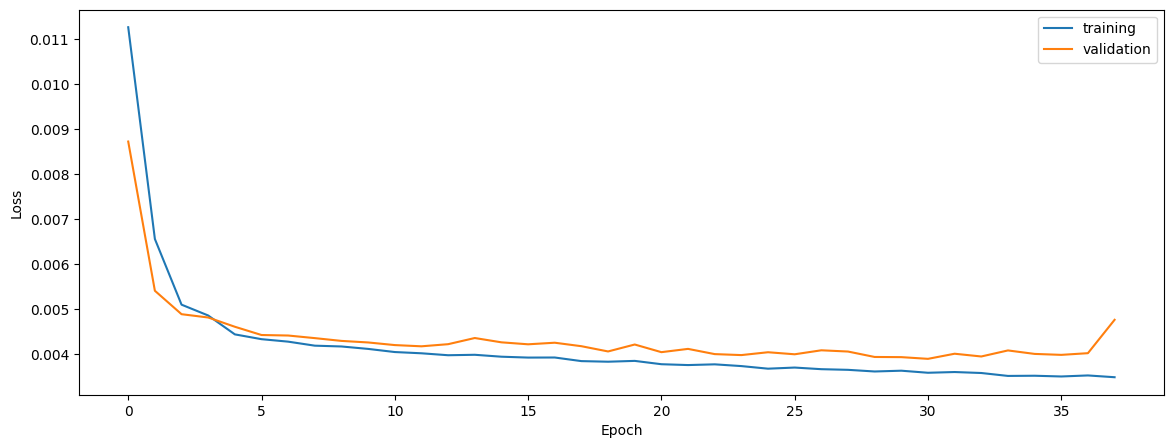

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8075092307703357
0.8006480922141156
0.7574019122005554


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8075092307703357
0.8006480922141156
0.7574019122005554


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8081450384638412
0.8056498922732379
0.7644841687835886


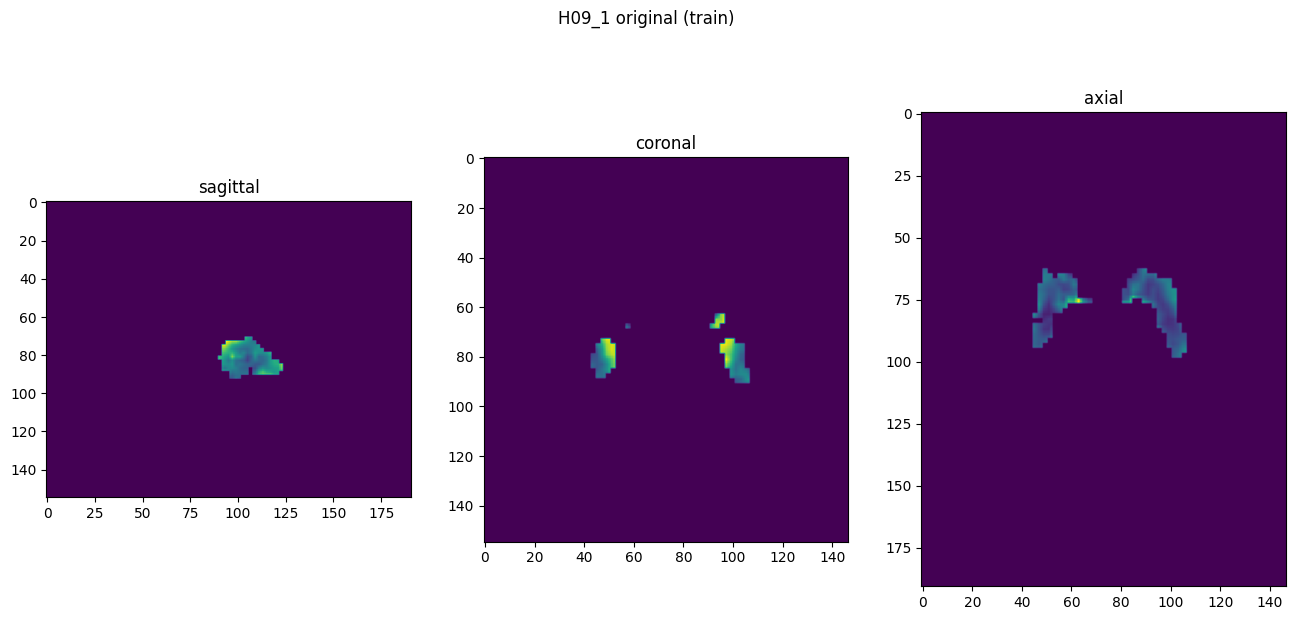

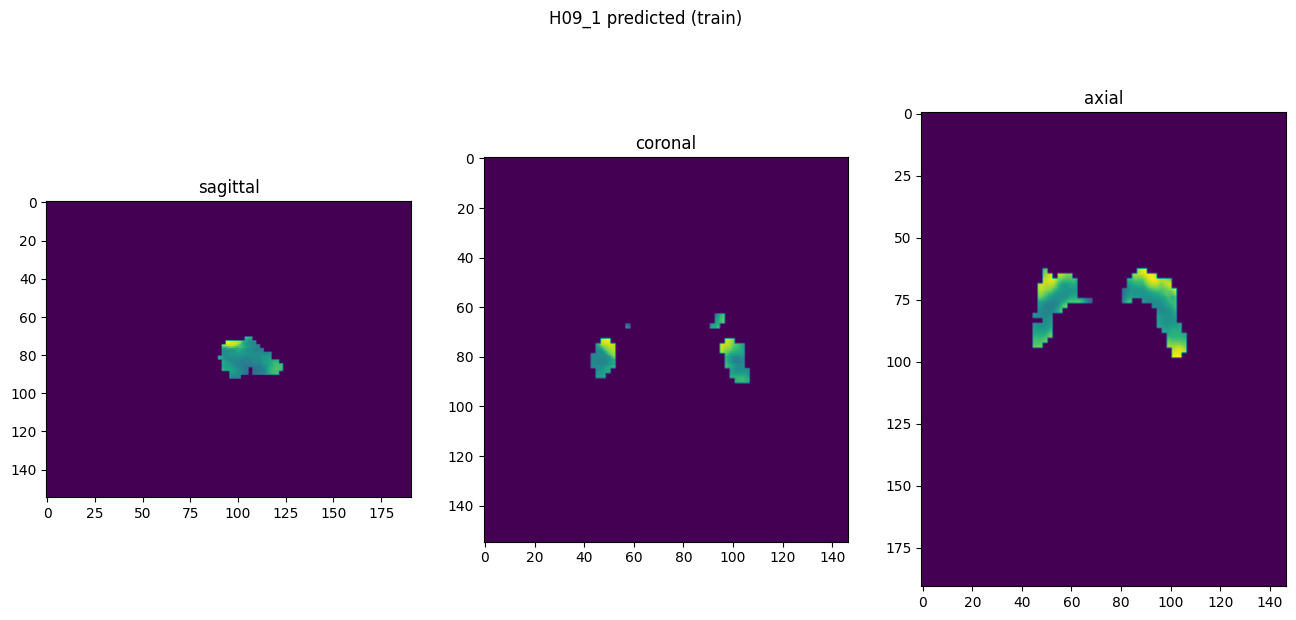

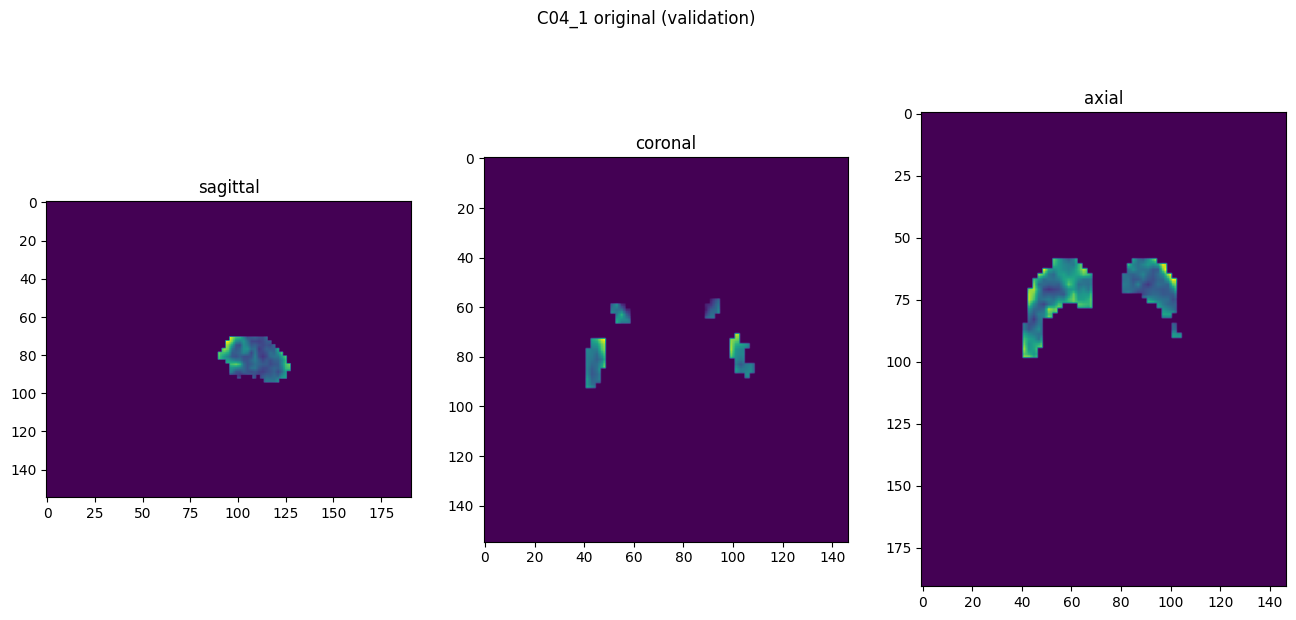

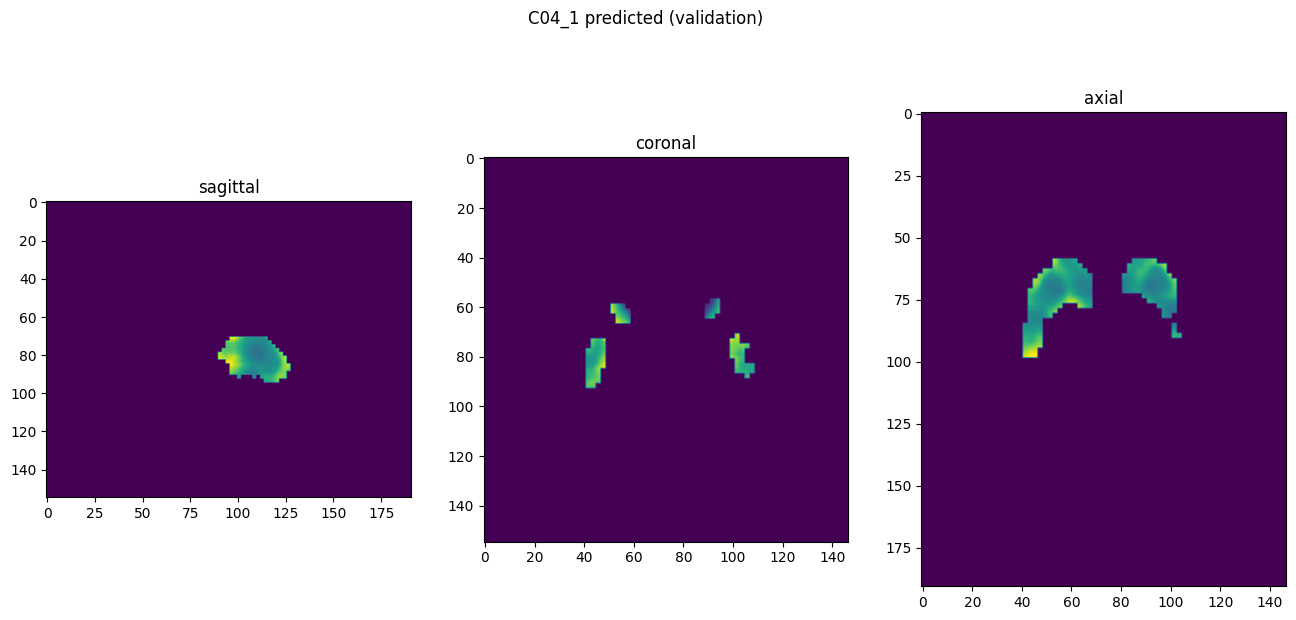

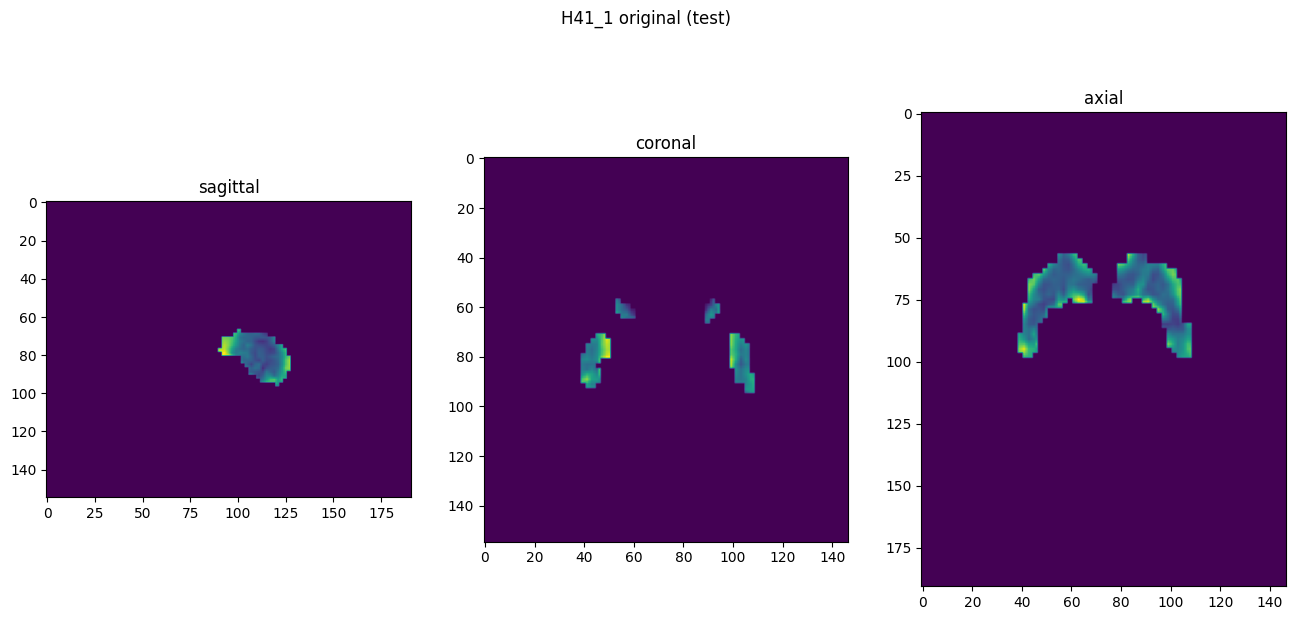

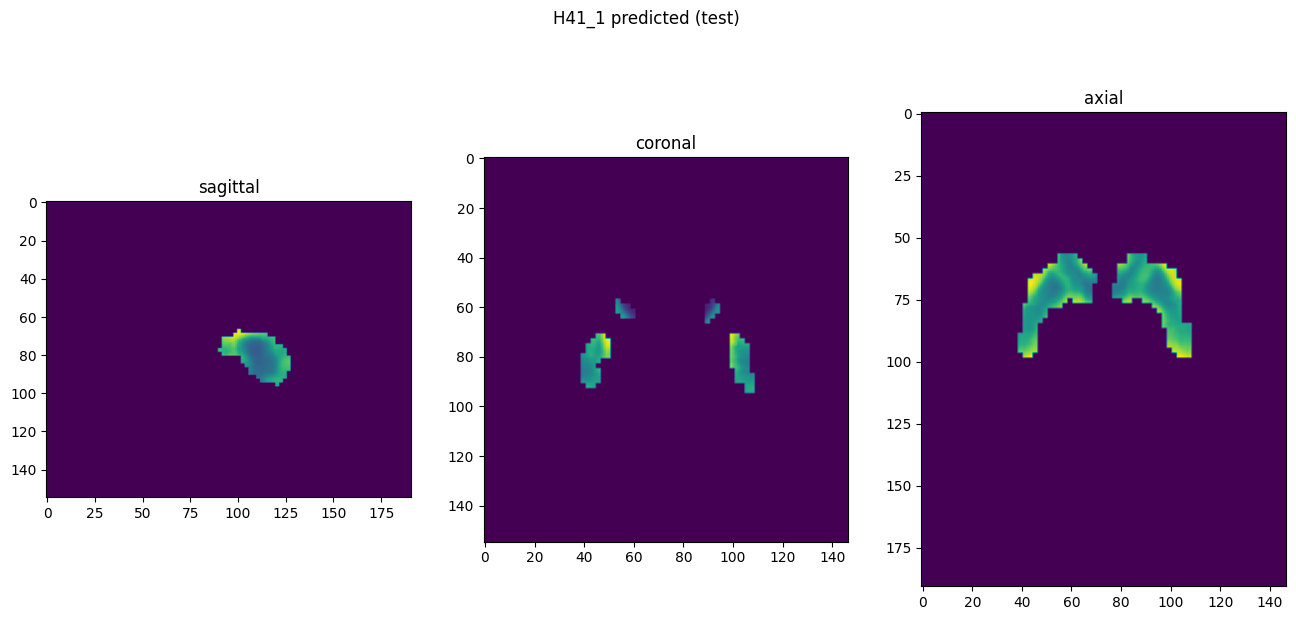

In [10]:
showResults(model, gen, threshold=None, background=False)